## Merge manual annotations

In this notebook I collect the manual annotations saved in `Pan_fetal_immune/manual_annotation` and add them to the full atlas. In addition I record the assignment of cells to hierarchical splits in the `obs` of the full Pan Fetal Immune atlas.

In [3]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from time import time
from datetime import datetime
import seaborn as sns

In [177]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/collapse_annotation/"
if os.path.exists(figdir):
    sc.settings.figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/"
else:
    os.mkdir(figdir)
    sc.settings.figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/"
    

## Load PFI data

In [69]:
adata

AnnData object with n_obs × n_vars = 897341 × 3195 backed at '/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.h5ad'
    obs: 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'Sample.lanes', 'Sort_id', 'age', 'method', 'sex', 'Processing_method', 'AnnatomicalPart', 'leiden_100', 'leiden_150', 'isin_split_NKT_CLEAN', 'isin_split_B_CLEAN_CLEAN', 'isin_split_MYELOID_LYMPHOID', 'isin_split_STROMA', 'isin_split_MYELOID', 'isin_split_LYMPHOID', 'anno_lvl_1_LYMPHOID', 'anno_lvl_2_LYMPHOID', 'anno_lvl_1_MYELOID', 'anno_lvl_2_MYELOID', 'anno_lvl_1_MEM_PROGENITORS', 'anno_lvl_2_MEM_PROGENITORS', 'is_annotated', 'is_uniquely_annotated'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'method_colors', 'neighbors', 'organ_colors', 'pca', 'umap'
 

In [65]:
## Load data
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
PFI_prefix = "PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118"

adata = sc.read_h5ad(data_dir + PFI_prefix + ".h5ad", backed="r")

New obs including annotations and split information made running `utils/collapse_annotation.py`

In [352]:
data_dir + PFI_prefix + '.full_obs.annotated.csv'

'/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.full_obs.annotated.csv'

In [78]:
adata_obs = pd.read_csv(data_dir + PFI_prefix + '.full_obs.annotated.csv', index_col=0)

In [79]:
adata.obs = adata_obs.loc[adata.obs_names]

... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'anno_lvl_1_LYMPHOID' as categorical
... storing 'anno_lvl_2_LYMPHOID' as categorical
... storing 'anno_lvl_1_MYELOID' as categorical
... storing 'anno_lvl_2_MYELOID' as categorical
... storing 'anno_lvl_1_MEM_PROGENITORS' as categorical
... storing 'anno_lvl_2_MEM_PROGENITORS' as categorical


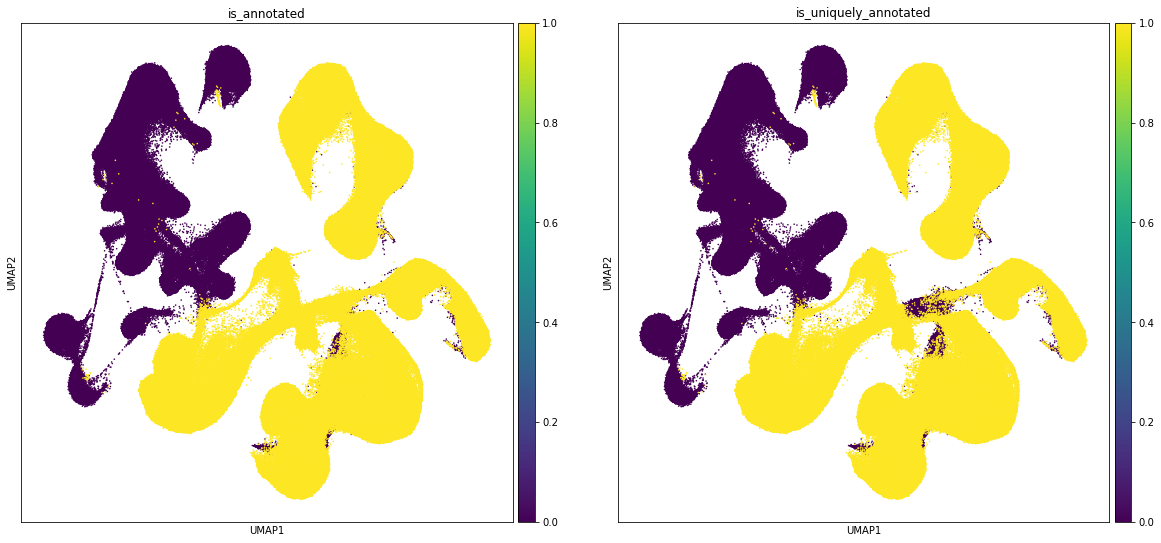

In [80]:
plt.rcParams["figure.figsize"] = [9,9]
sc.pl.umap(adata, color=["is_annotated","is_uniquely_annotated"], size=10)

In [139]:
spl_cols = [x for x in adata_obs.columns if "isin" in x]
adata.obs[spl_cols] = adata.obs[spl_cols].astype('int')
adata.obs[spl_cols]

,isin_split_NKT,isin_split_B_CLEAN,isin_split_MYELOID_LYMPHOID,isin_split_STROMA,isin_split_MYELOID_CLEAN,isin_split_LYMPHOID,isin_split_MEM_PROGENITORS
index,,,,,,,
FCAImmP7179363-AAACCTGAGCAGATCG,0,0,1,0,1,0,0
FCAImmP7179363-AAACCTGAGCTGATAA,0,0,1,0,1,0,0
FCAImmP7179363-AAACCTGAGGGTTTCT,0,0,1,0,1,0,0
FCAImmP7179363-AAACCTGGTAGAGGAA,0,0,0,0,0,0,1
FCAImmP7179363-AAACCTGGTCTTTCAT,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...
TTTGGTTTCTTGTTTG-1_Human_colon_16S7985391,0,0,0,1,0,0,0
TTTGTCAAGCCAGTAG-1_Human_colon_16S7985391,0,0,0,1,0,0,0
TTTGTCAGTCCTCTTG-1_Human_colon_16S7985391,0,0,0,1,0,0,0


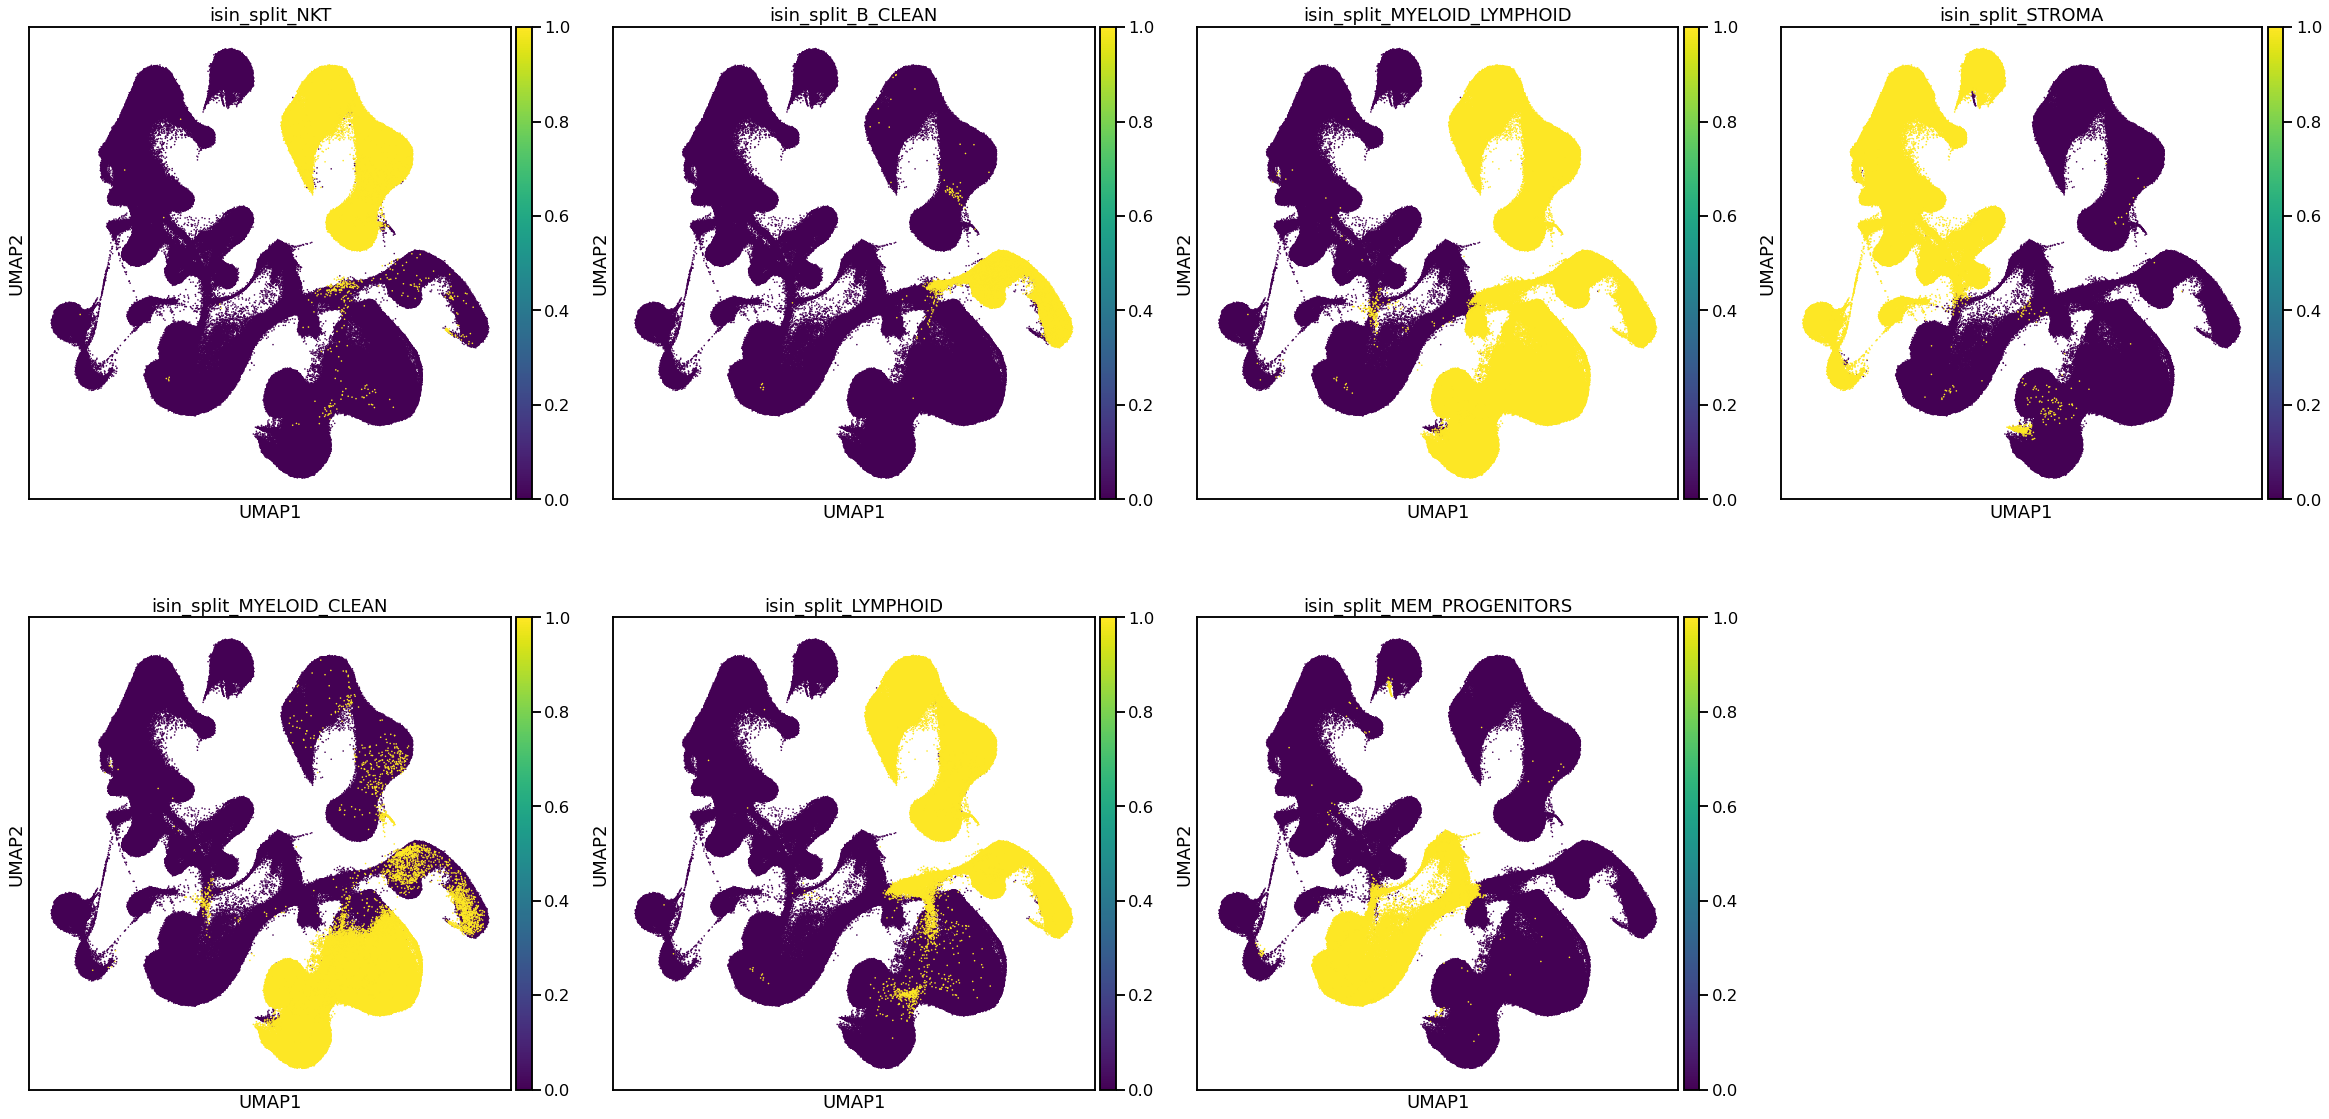

In [158]:
sns.set_context("talk")
sc.pl.umap(adata, color=spl_cols, size=10, save='splits_PFI.png')

## Plot matching of cells to splits

In [81]:
%load_ext rpy2.ipython

In [82]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [162]:
spl_cols = [x for x in adata_obs.columns if "isin" in x]
pl_df = adata_obs[spl_cols]
pl_df["count"] = 1
# pl_df = pl_df.groupby(spl_cols).count().reset_index()
pl_df = pl_df.groupby(spl_cols).sample(frac=0.01)
pl_df[spl_cols] = pl_df[spl_cols].astype("int")
spl_cols = np.array([x for x in adata_obs.columns if "isin" in x])

split_counts = adata_obs[spl_cols].sum(0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Joining, by = "name"


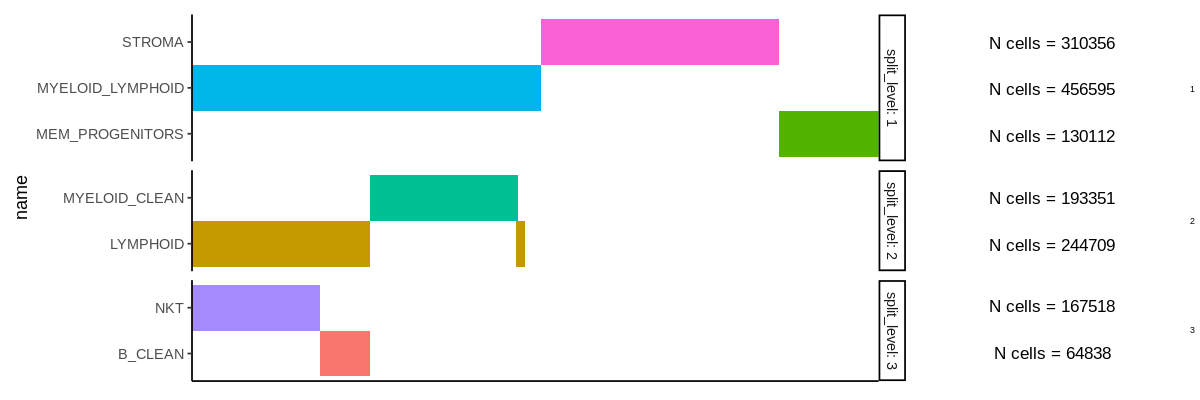

In [182]:
%%R -i pl_df -i spl_cols -i split_counts -i figdir -w 1200 -h 400
library(patchwork)

counts_df <- data.frame(split_counts) %>%
    rownames_to_column() %>%
    mutate(rowname=str_remove(rowname, 'isin_split_')) %>%
    rename(name=rowname)

df <- pl_df %>%
rownames_to_column() %>%
pivot_longer(cols=all_of(spl_cols))  %>%
mutate(name=str_remove(name, "isin_split_")) %>%
mutate(split_level = case_when(name %in% c("STROMA", "MYELOID_LYMPHOID", "MEM_PROGENITORS") ~ 1,
                             name %in% c("MYELOID_CLEAN","LYMPHOID") ~ 2,
                             name %in% c("B_CLEAN","NKT") ~ 3,
                            )) %>%
arrange( - split_level ) %>%
mutate(name=factor(name, levels=unique(name))) %>%
arrange(name) %>%
group_by(name) %>%
# ungroup() %>%
filter(value==1) %>%
mutate(rowname=factor(rowname, unique(rowname))) %>%
left_join(counts_df) %>%
rename(n_cells=split_counts) 

p1 <- df %>%
ggplot(aes(rowname, name, fill=name)) + 
geom_tile() +
theme_classic(base_size=18) +
theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.title.x=element_blank()) +
guides(fill="none") +
facet_grid(split_level ~., scales="free", space="free", labeller="label_both") 
# coord_flip()
# geom_tile(aes(fill=value))

p2 <- df %>%
    distinct(name, n_cells, split_level) %>%
    ggplot(aes(name, 1, fill=name)) +
    geom_text(aes(label=paste0("N cells = ",n_cells)), size=6) +
    coord_flip() +
    theme_classic(base_size=18) +
    theme_void() +
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank()) +
    guides(fill="none") +
    facet_grid(split_level ~., scales="free", space="free") 


p1 + p2 +
    plot_layout(widths=c(2.5,1)) +
    ggsave(paste0(figdir, "splitting_scheme.png"), width=12, height=5)

## Organ VS annotation

In [250]:
anno_df = adata[adata.obs['is_uniquely_annotated']==1].obs.copy()

anno_cols = [x for x in adata_obs.columns if "anno_lvl_2" in x]
anno_df["anno_lvl_2"] = anno_df[anno_cols[0]].astype("str")
anno_df.loc[anno_df["anno_lvl_2"]=="nan","anno_lvl_2"] = anno_df.loc[anno_df["anno_lvl_2"]=="nan",anno_cols[1]].astype("str")
anno_df.loc[anno_df["anno_lvl_2"]=="nan","anno_lvl_2"] = anno_df.loc[anno_df["anno_lvl_2"]=="nan",anno_cols[2]].astype("str")

anno_cols = [x for x in adata_obs.columns if "anno_lvl_1" in x]
anno_df["anno_lvl_1"] = anno_df[anno_cols[0]].astype("str")
anno_df.loc[anno_df["anno_lvl_1"]=="nan","anno_lvl_1"] = anno_df.loc[anno_df["anno_lvl_1"]=="nan",anno_cols[1]].astype("str")
anno_df.loc[anno_df["anno_lvl_1"]=="nan","anno_lvl_1"] = anno_df.loc[anno_df["anno_lvl_1"]=="nan",anno_cols[2]].astype("str")

anno_df['anno_col'] = np.nan
for c in anno_cols:
    anno_df.loc[anno_df[c]!="nan", "anno_col"] = c

anno_df["anno_col"] = [x.split("anno_lvl_1_")[1] for x in anno_df["anno_col"]]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [251]:
anno_df["counts"]=1
anno_df["organ"] = [x if x!="TH(pharyn)" else "TH" for x in anno_df["organ"]]
org_ct_counts = anno_df[["organ", "anno_lvl_2", "anno_col", "counts"]].groupby(["organ","anno_lvl_2", "anno_col"]).sum('counts').reset_index()

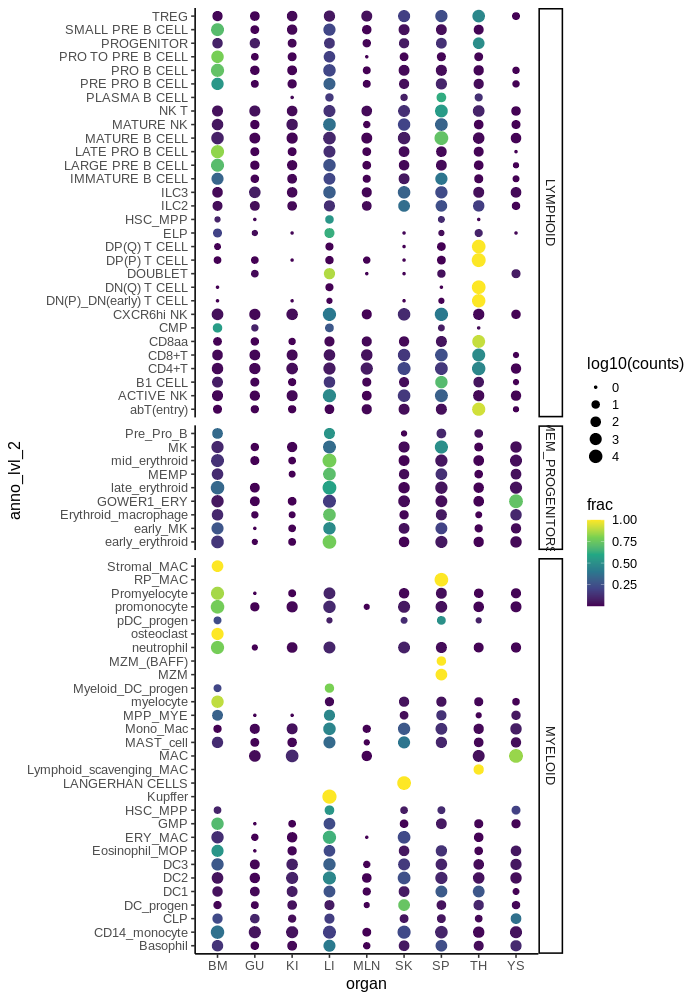

In [351]:
%%R -i org_ct_counts -h 1000 -w 700
organs <- unique(org_ct_counts$organ)

frac_df <- org_ct_counts %>%
    group_by(anno_lvl_2) %>%
    mutate(n_tot=sum(counts)) %>%
    ungroup() %>%
    group_by(organ, anno_lvl_2) %>%
    mutate(frac=sum(counts)/n_tot) %>%
    ungroup() 
#     select(organ, anno_lvl_2, )
#     pivot_wider(id_cols=c("anno_lvl_2", 'anno_col'), names_from="organ", values_from="frac", values_fill=0) %>%
#     pivot_longer(cols=c(organs), names_to="organ", values_to="frac") 
    
frac_df %>%
    ggplot(aes(organ, anno_lvl_2, color=frac)) +
    geom_point(aes(size=log10(counts))) +
    scale_color_viridis_c() +
    facet_grid(anno_col~., space="free", scales="free") +
    theme_classic(base_size=16)

### Using scCODA 

In [269]:
metadata_df = anno_df[["anno_lvl_2", "organ", "age", "Sample", "Sort_id"]]
metadata_df = metadata_df[~metadata_df.anno_lvl_2.isna()]

## Make obs for pseudobulk
group_by = ["Sample", "anno_lvl_2"]
pseudobulk_obs = metadata_df[group_by].drop_duplicates()
pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)

metadata_df["pseudobulk_sample"] = metadata_df[group_by].agg("-".join, axis=1)

## Add number of cells to obs 
n_cells = metadata_df.groupby('pseudobulk_sample').count().iloc[:,0]
n_cells.name = "n_cells"
pseudobulk_obs = pd.concat([pseudobulk_obs, n_cells], axis=1)

cell_counts = pseudobulk_obs[["Sample",'anno_lvl_2',"n_cells"]].pivot(index='Sample', columns="anno_lvl_2", values="n_cells").fillna(0)
cell_counts = cell_counts.reset_index()

In [270]:
cell_counts.index = cell_counts["Sample"]

In [279]:
## Match sample 2 covariates
sample2cov = metadata_df[["Sample", "organ", "age", "Sort_id"]].drop_duplicates()
sample2cov.index = sample2cov.Sample

cell_counts = pd.concat([cell_counts, sample2cov], 1)


Convert 2 anndata

In [273]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["organ", "Sample", "Sort_id", "age"])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [317]:
data_all.obs.loc[data_all.obs["organ"] == 'TH(pharyn)', "organ"]  = "TH"
data_all.var_names = [x.upper() for x in data_all.var_names]

In [295]:
lymph = anno_df[anno_df["anno_col"] == "LYMPHOID"]["anno_lvl_2"].unique()

In [296]:
lymph

array(['CXCR6hi NK', 'MATURE B CELL', 'ACTIVE NK', 'PRO B CELL',
       'IMMATURE B CELL', 'MATURE NK', 'LARGE PRE B CELL', 'CD4+T',
       'NK T', 'CD8+T', 'CD8aa', 'SMALL PRE B CELL', 'PRO TO PRE B CELL',
       'abT(entry)', 'TREG', 'B1 CELL', 'DOUBLET', 'PRE PRO B CELL',
       'LATE PRO B CELL', 'ILC2', 'PROGENITOR', 'ILC3', 'HSC_MPP', 'CMP',
       'ELP', 'PLASMA B CELL', 'DP(P) T CELL', 'DP(Q) T CELL',
       'DN(Q) T CELL', 'DN(P)_DN(early) T CELL'], dtype=object)

In [328]:
# all_labels = [x.upper() for x in data_all.var_names]
# anno_groups = adata.obs[['uniform_label', 'uniform_label_lvl0']].drop_duplicates()
anno_groups = {'T_cells' : [x for x in data_all.var_names if (x.endswith("T") or x.endswith("T CELL") or x=="TREG") and x != "DOUBLET"],
'NK_cells' : [x for x in data_all.var_names if x.endswith("NK")],
'B_cells' : [x for x in data_all.var_names if x.endswith("B") or x.endswith("B CELL") or x.endswith("B1 CELL")],
'ILC_cells' : [x for x in data_all.var_names if "ILC" in x],
'Prog_cells' : [x for x in data_all.var_names if x.endswith("P")],
'MK_cells' : [x for x in data_all.var_names if x.endswith("MK")],
'DC_cells' : [x for x in data_all.var_names if "DC" in x],
'MAC_cells' : [x for x in data_all.var_names if "MAC" in x],
'Ery_cells' : [x for x in data_all.var_names if "ERY" in x and "MAC" not in x],
              }

anno_groups['Ery_cells']

['GOWER1_ERY', 'EARLY_ERYTHROID', 'LATE_ERYTHROID', 'MID_ERYTHROID']

In [ ]:
## Rename sorts
data_all.obs.loc[data_all.obs["Sort_id"] == "CD45P_CD45N", "Sort_id"] = "CD45P"
data_all.obs[data_all.obs["Sort_id"] == "CD45P"].drop_duplicates("organ")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/data_visualization.py:234: RuntimeWarning: invalid value encountered in true_divide
  X = data.X/sample_sums
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/data_visualization.py:234: RuntimeWarning: invalid value encountered in true_divide
  X = data.X/sample_sums
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/

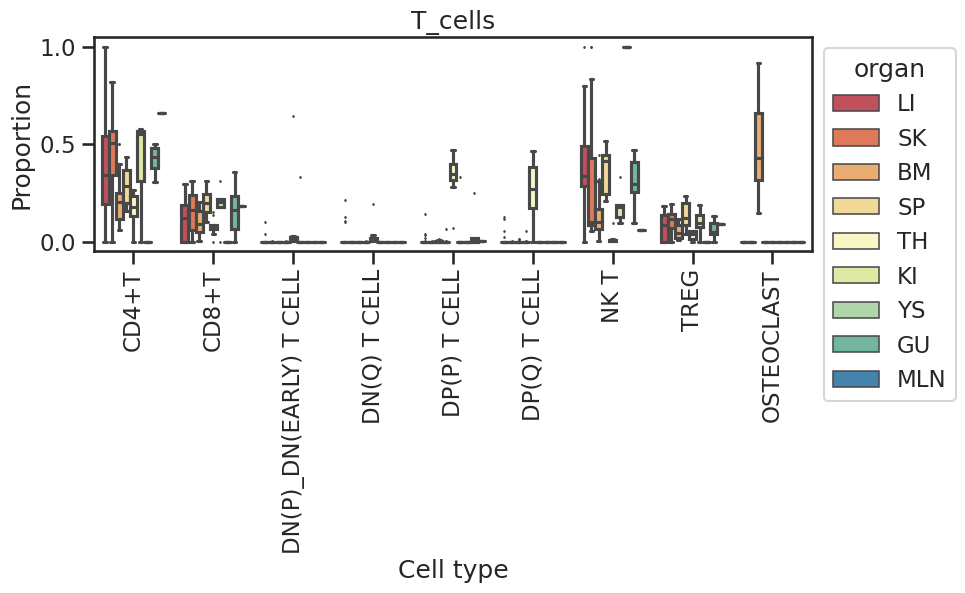

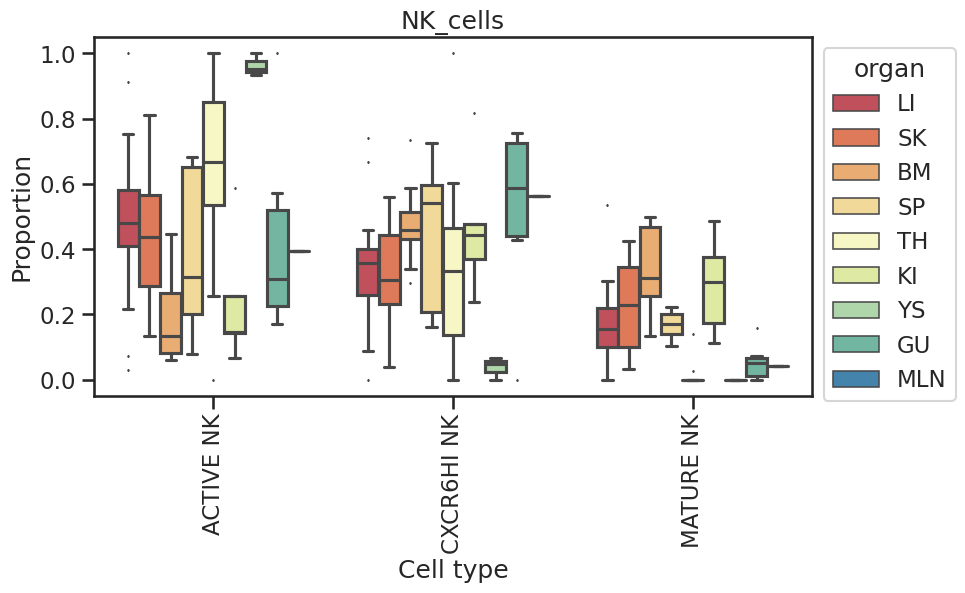

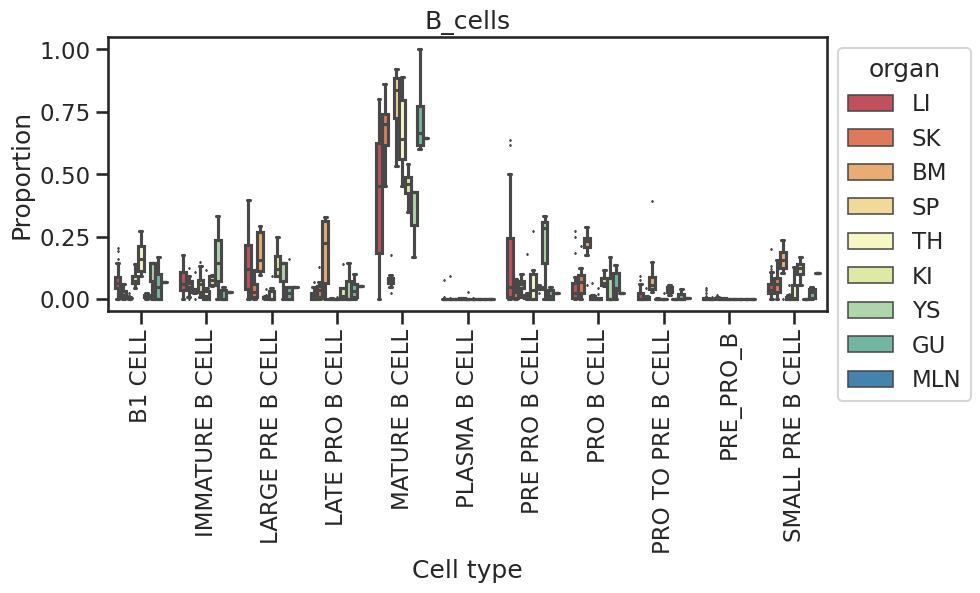

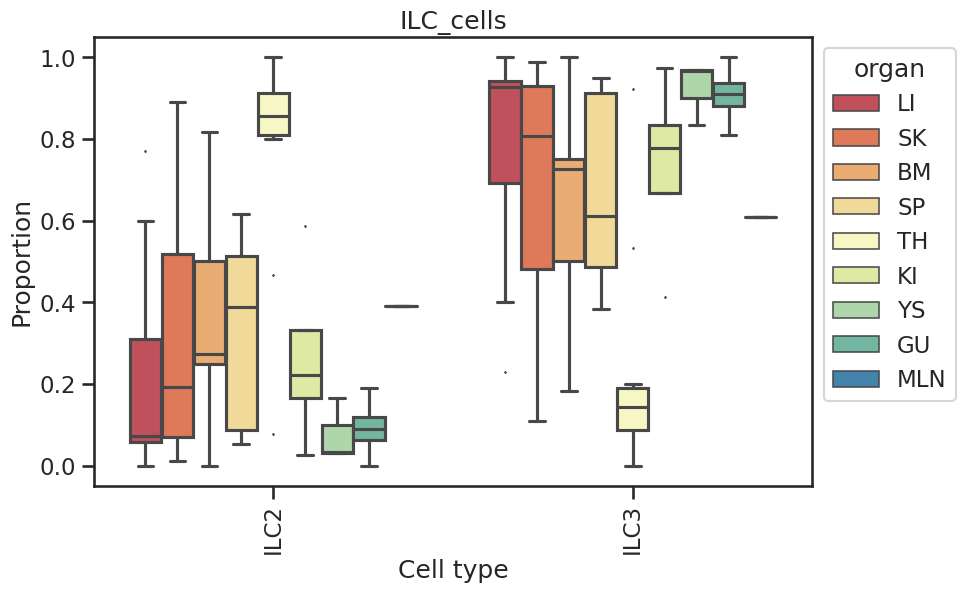

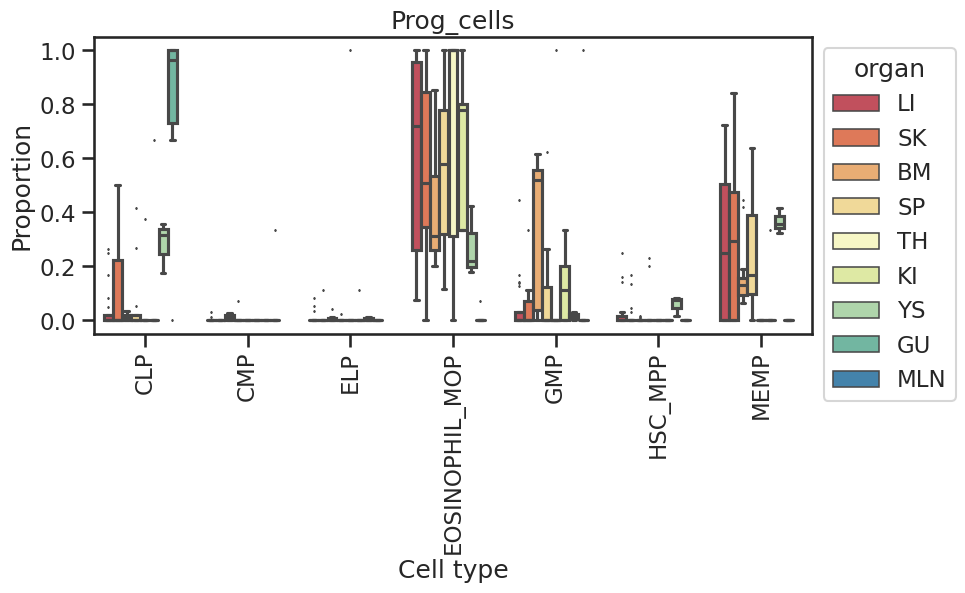

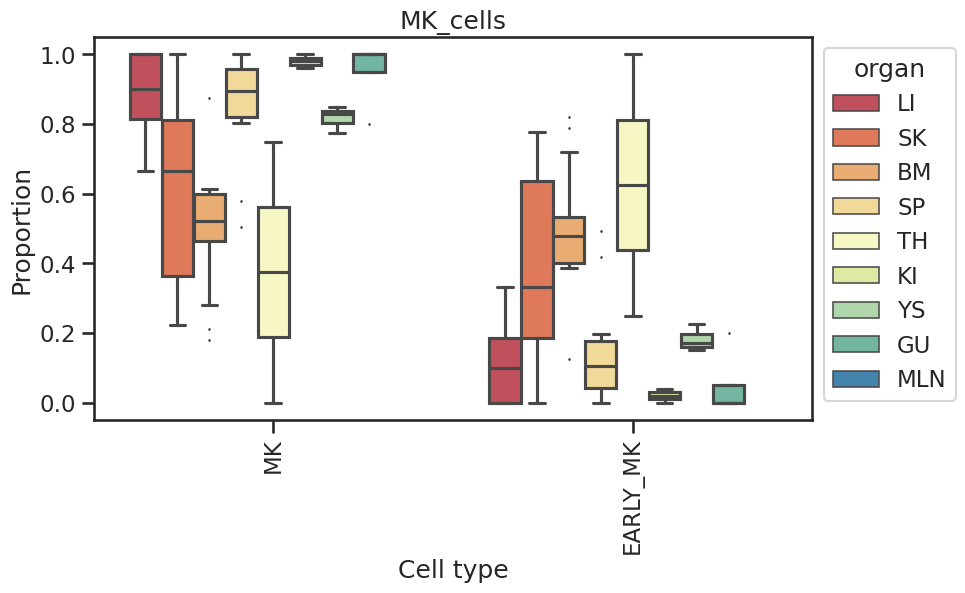

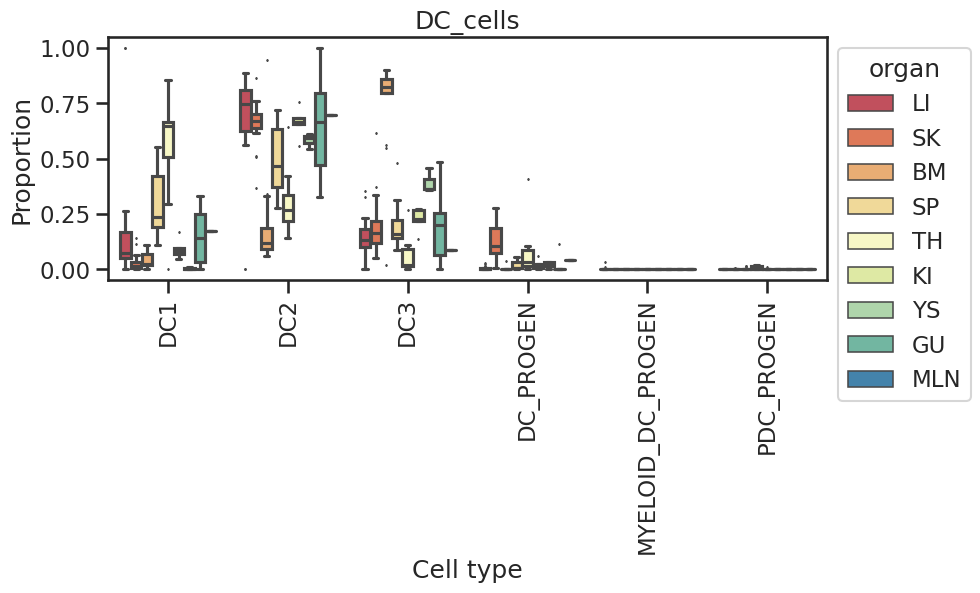

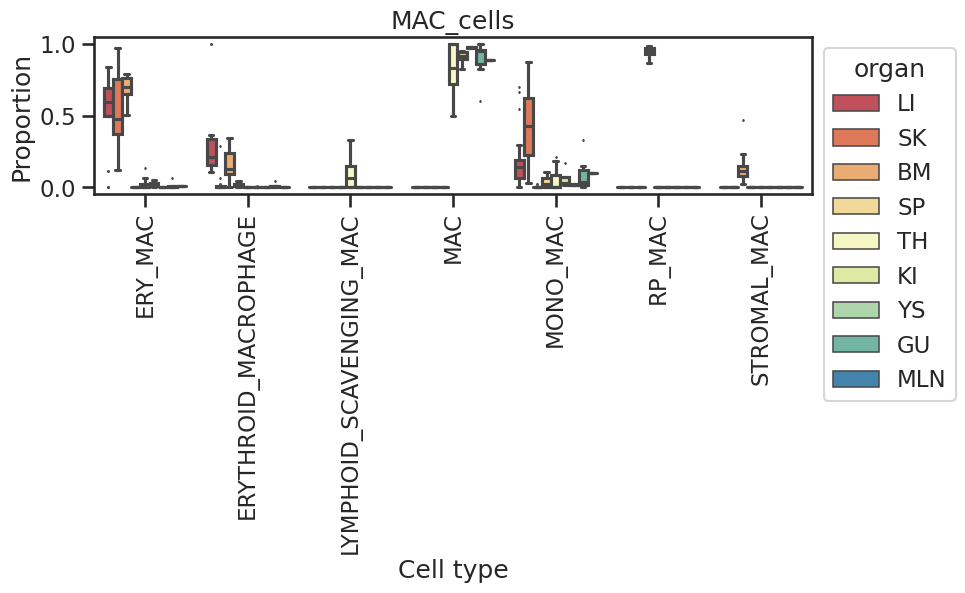

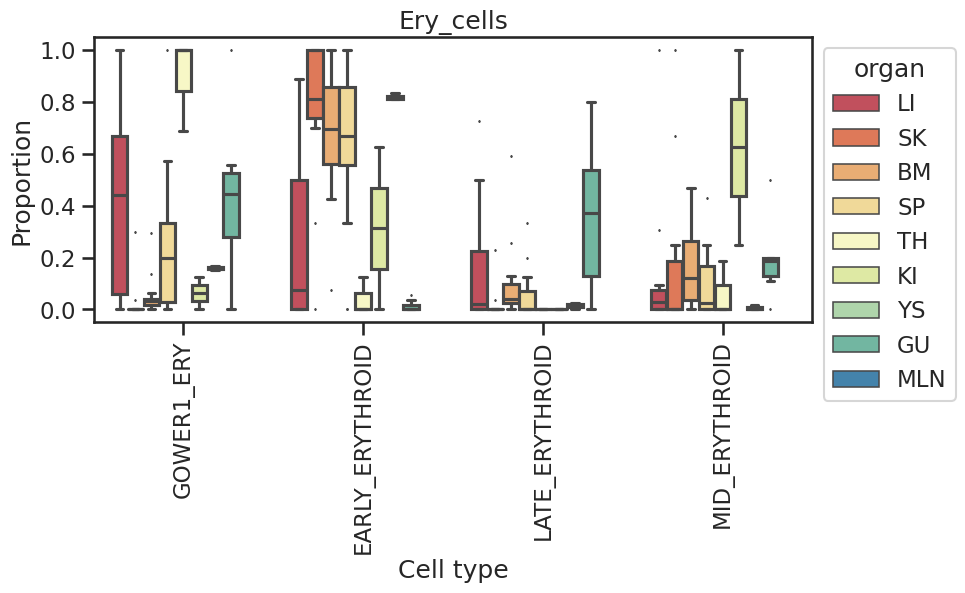

In [344]:
plt.rcParams["figure.figsize"] = [10,6]
for k,g in anno_groups.items():
    viz.boxplots(data_all[data_all.obs["Sort_id"] == "CD45P"][:, g], feature_name="organ", cmap="Spectral", add_dots=False);
    plt.title(k)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/data_visualization.py:77: RuntimeWarning: invalid value encountered in double_scalars
  bars = [i / j * 100 for i, j in zip([y[k][n] for k in range(n_bars)], sample_sums)]


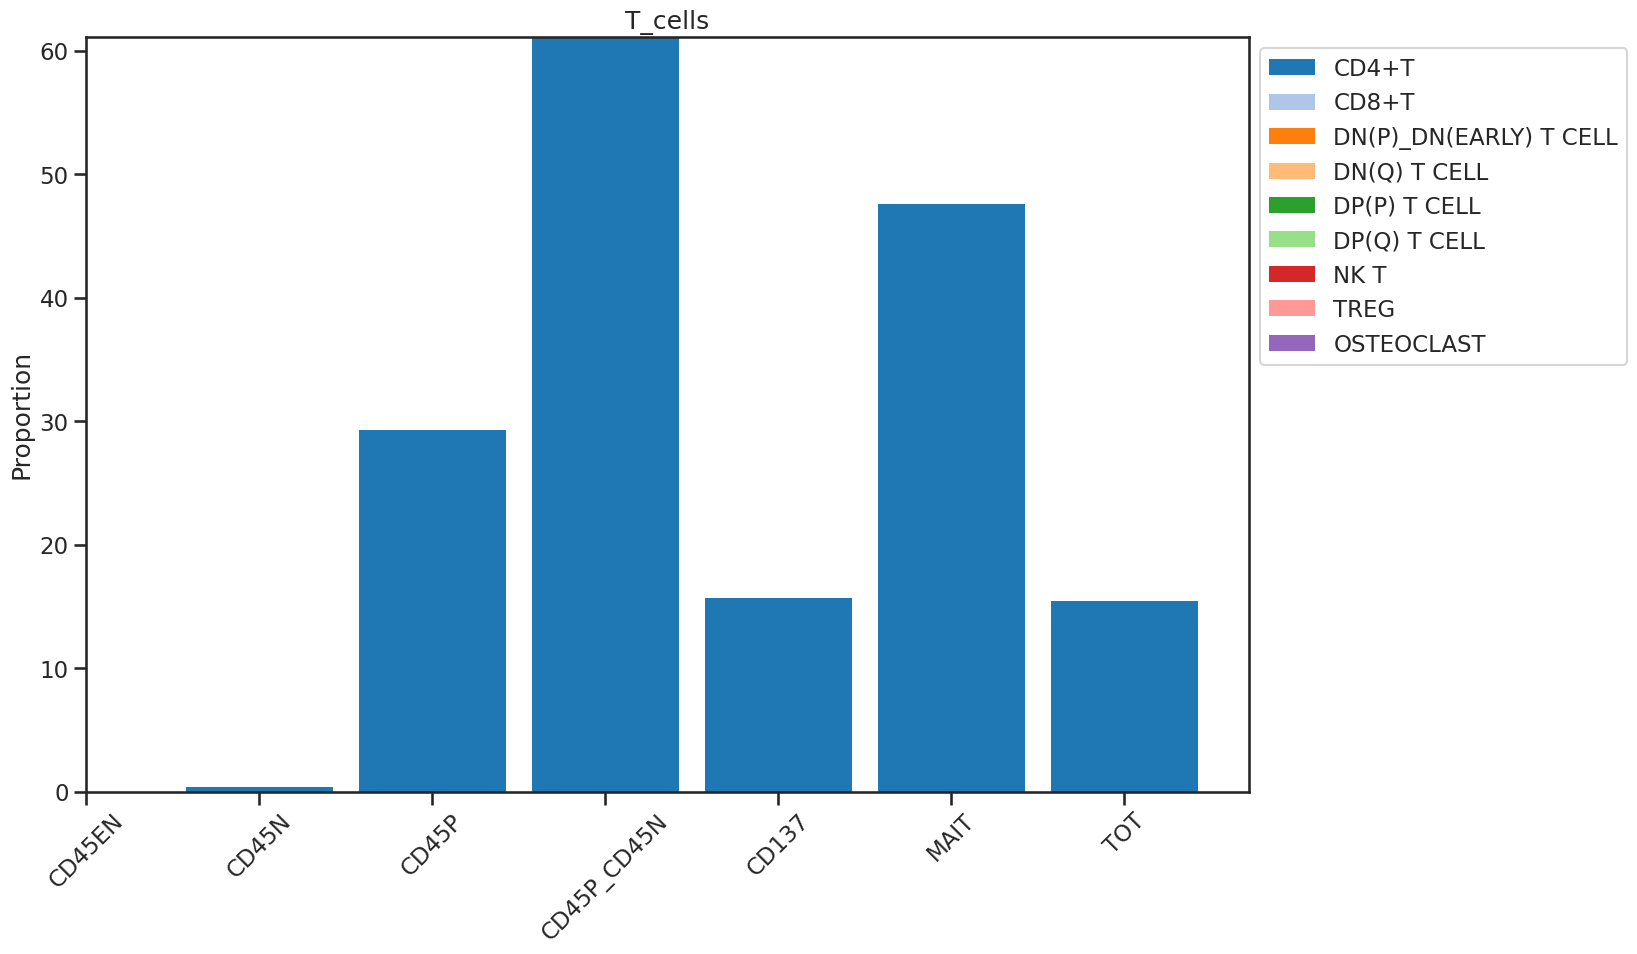

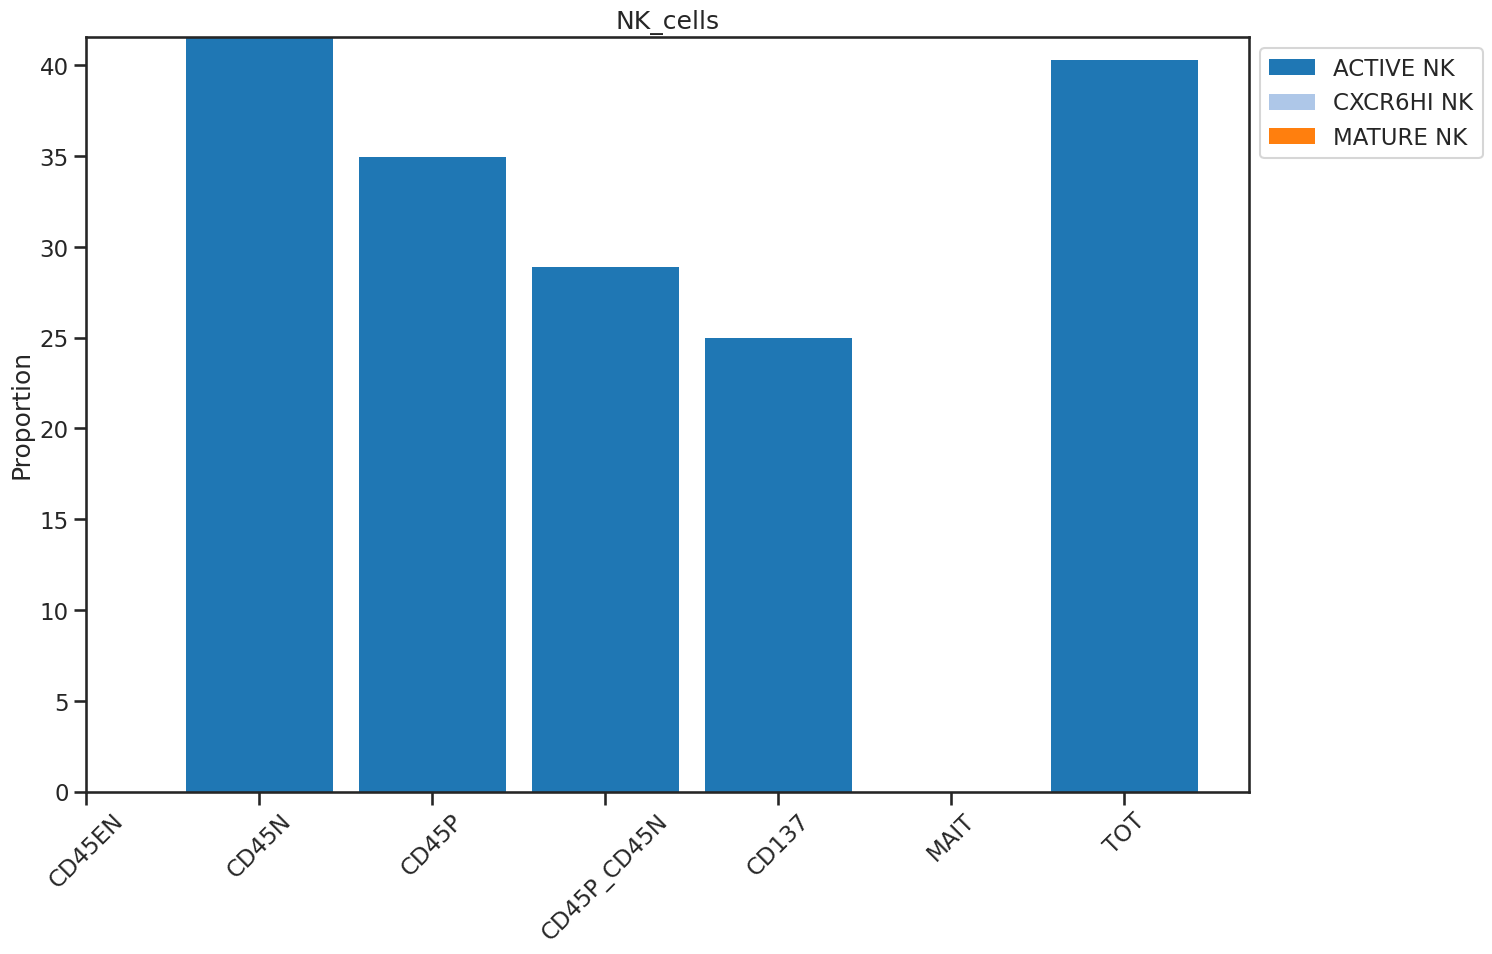

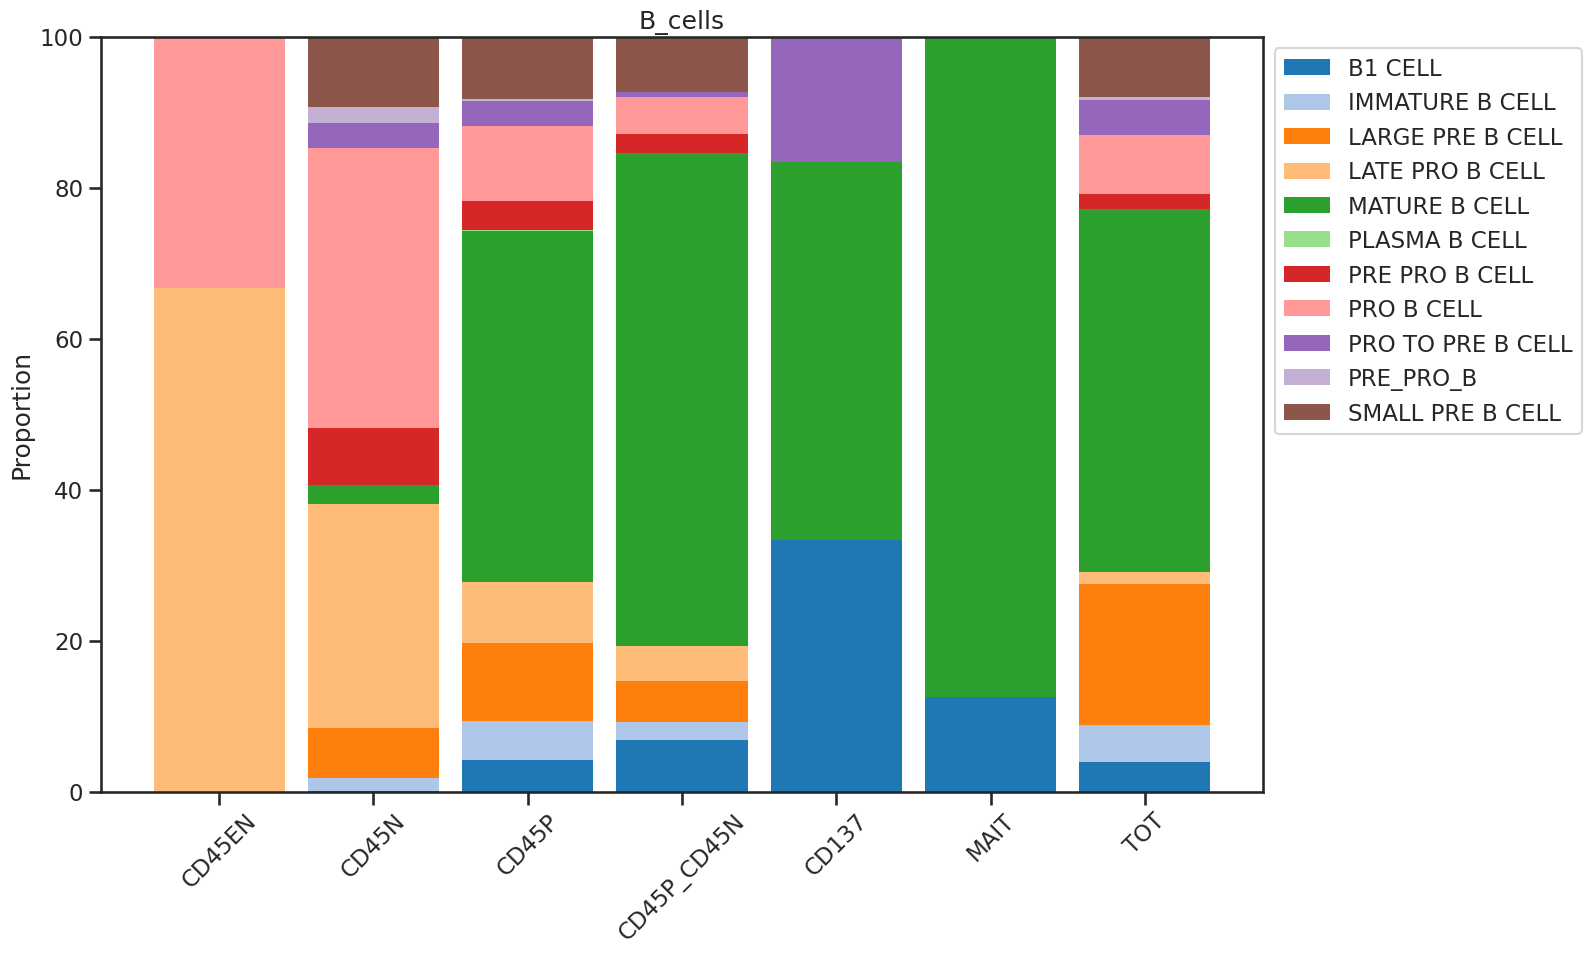

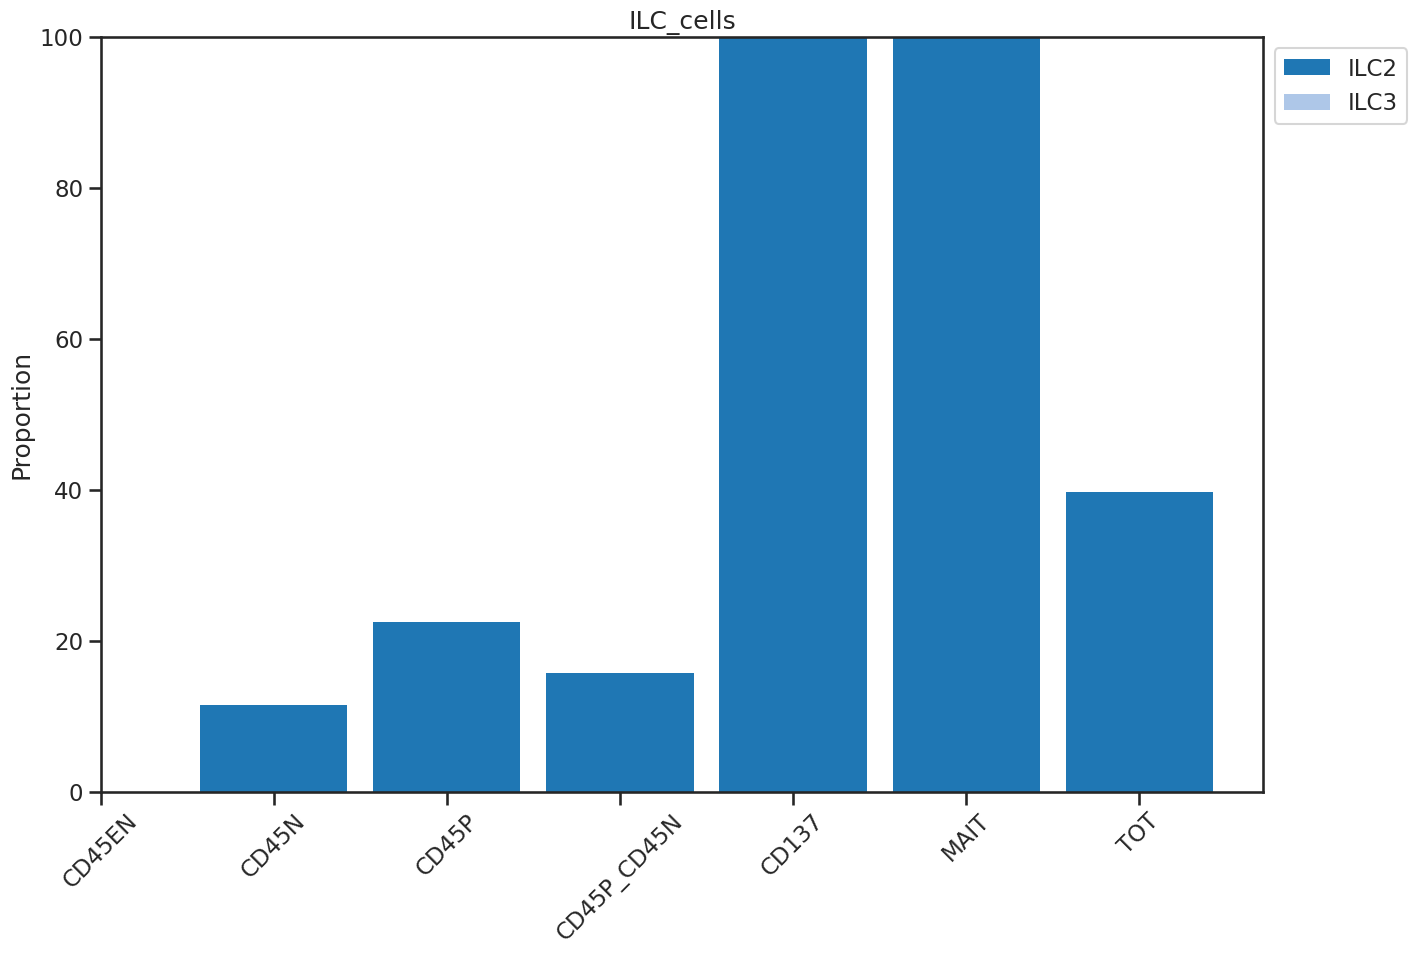

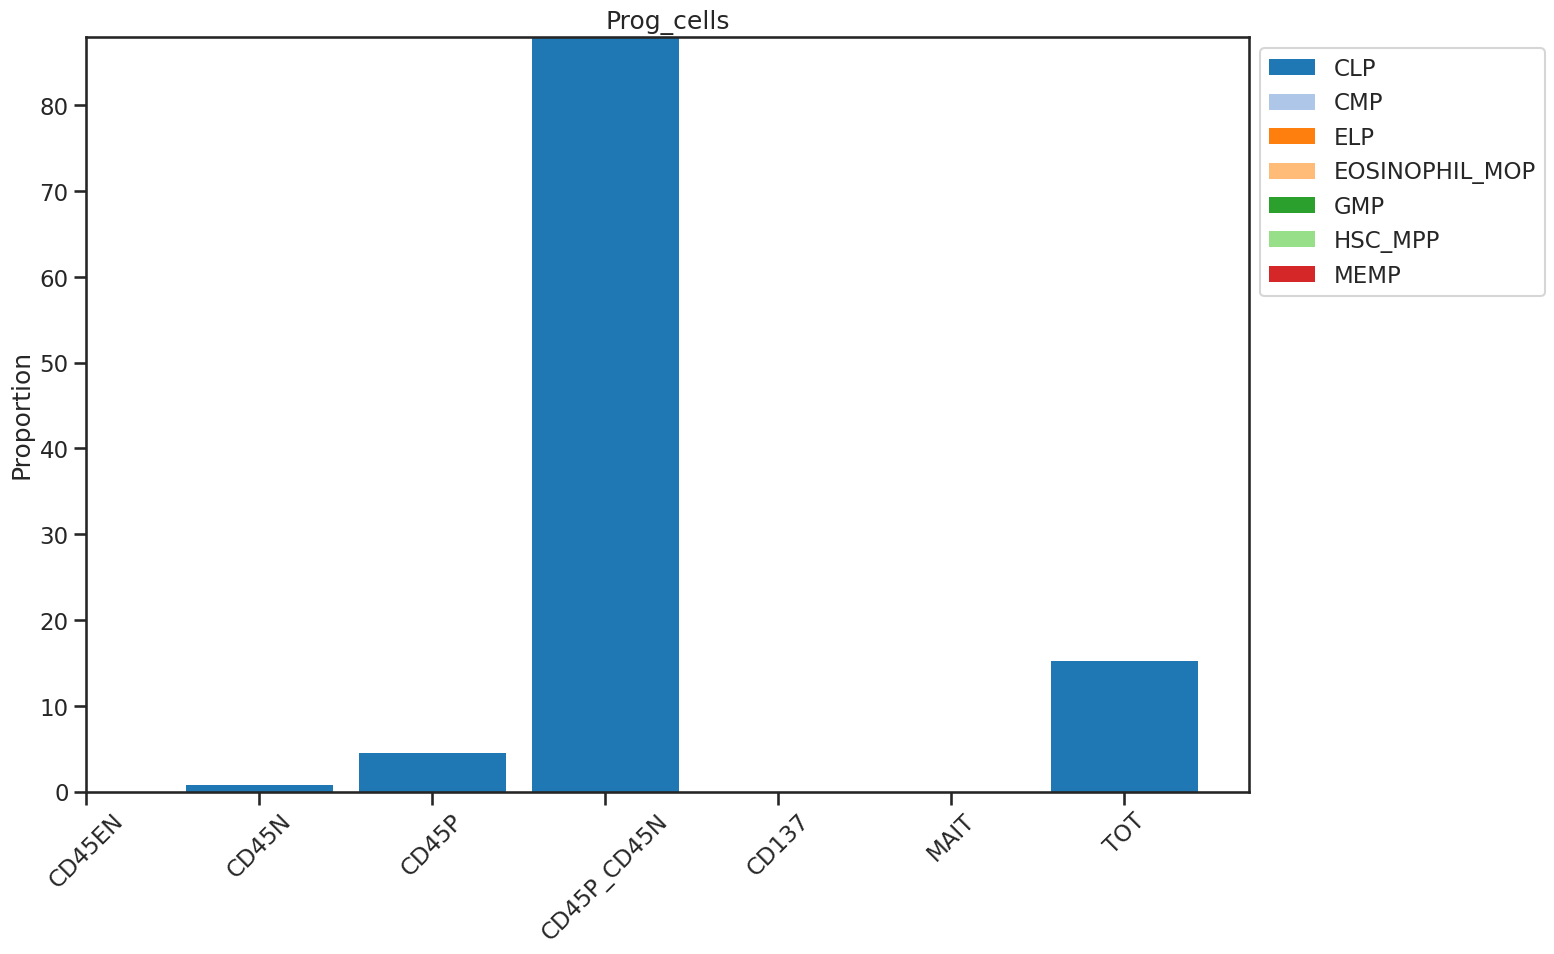

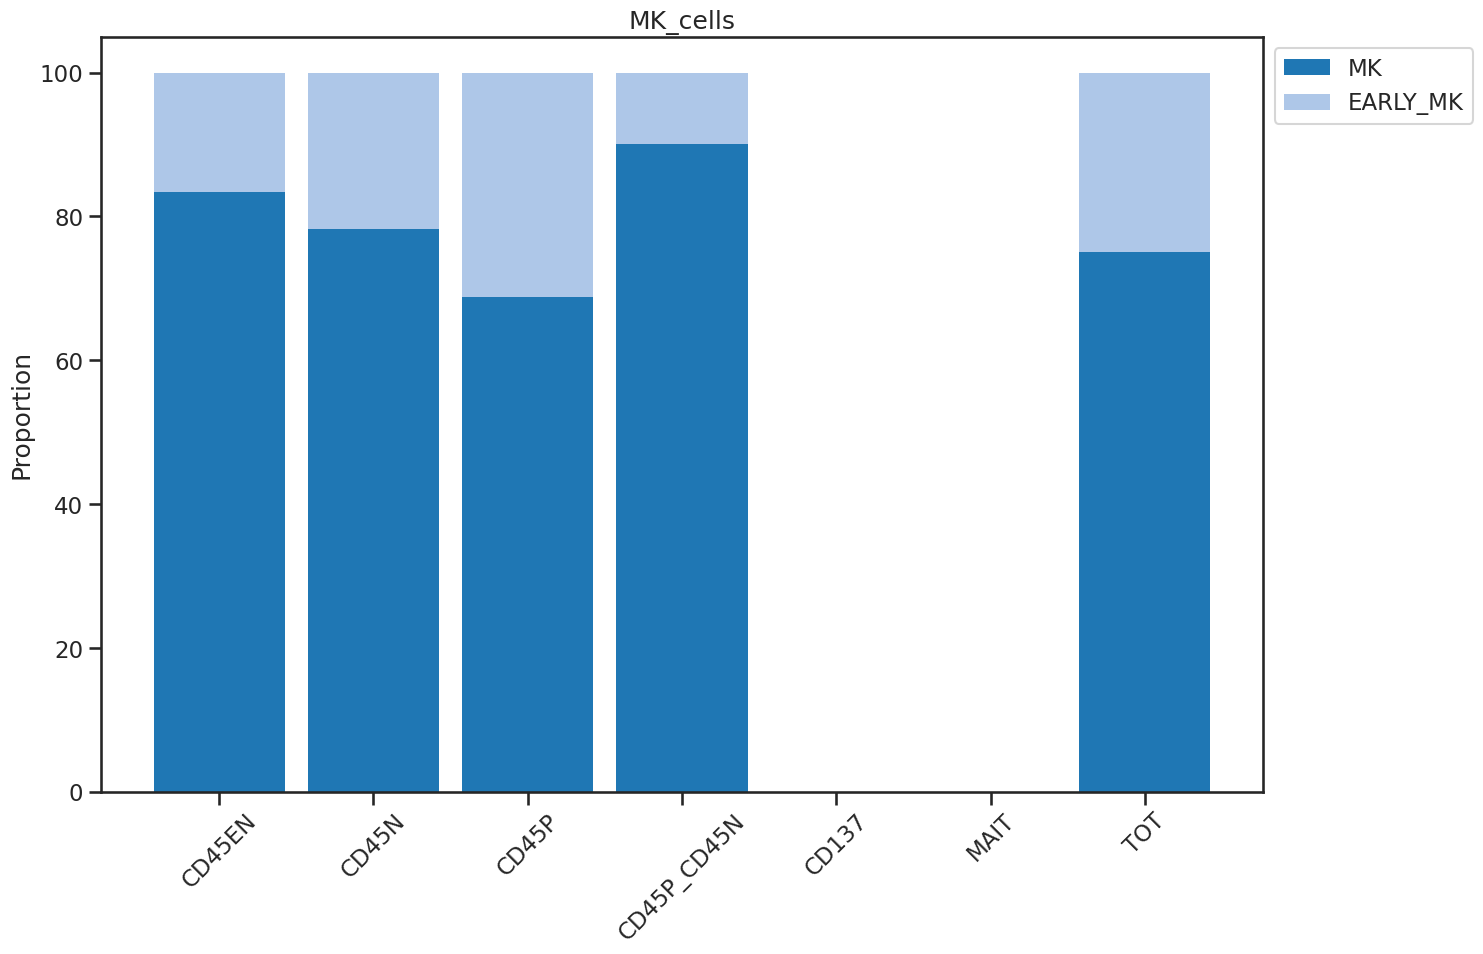

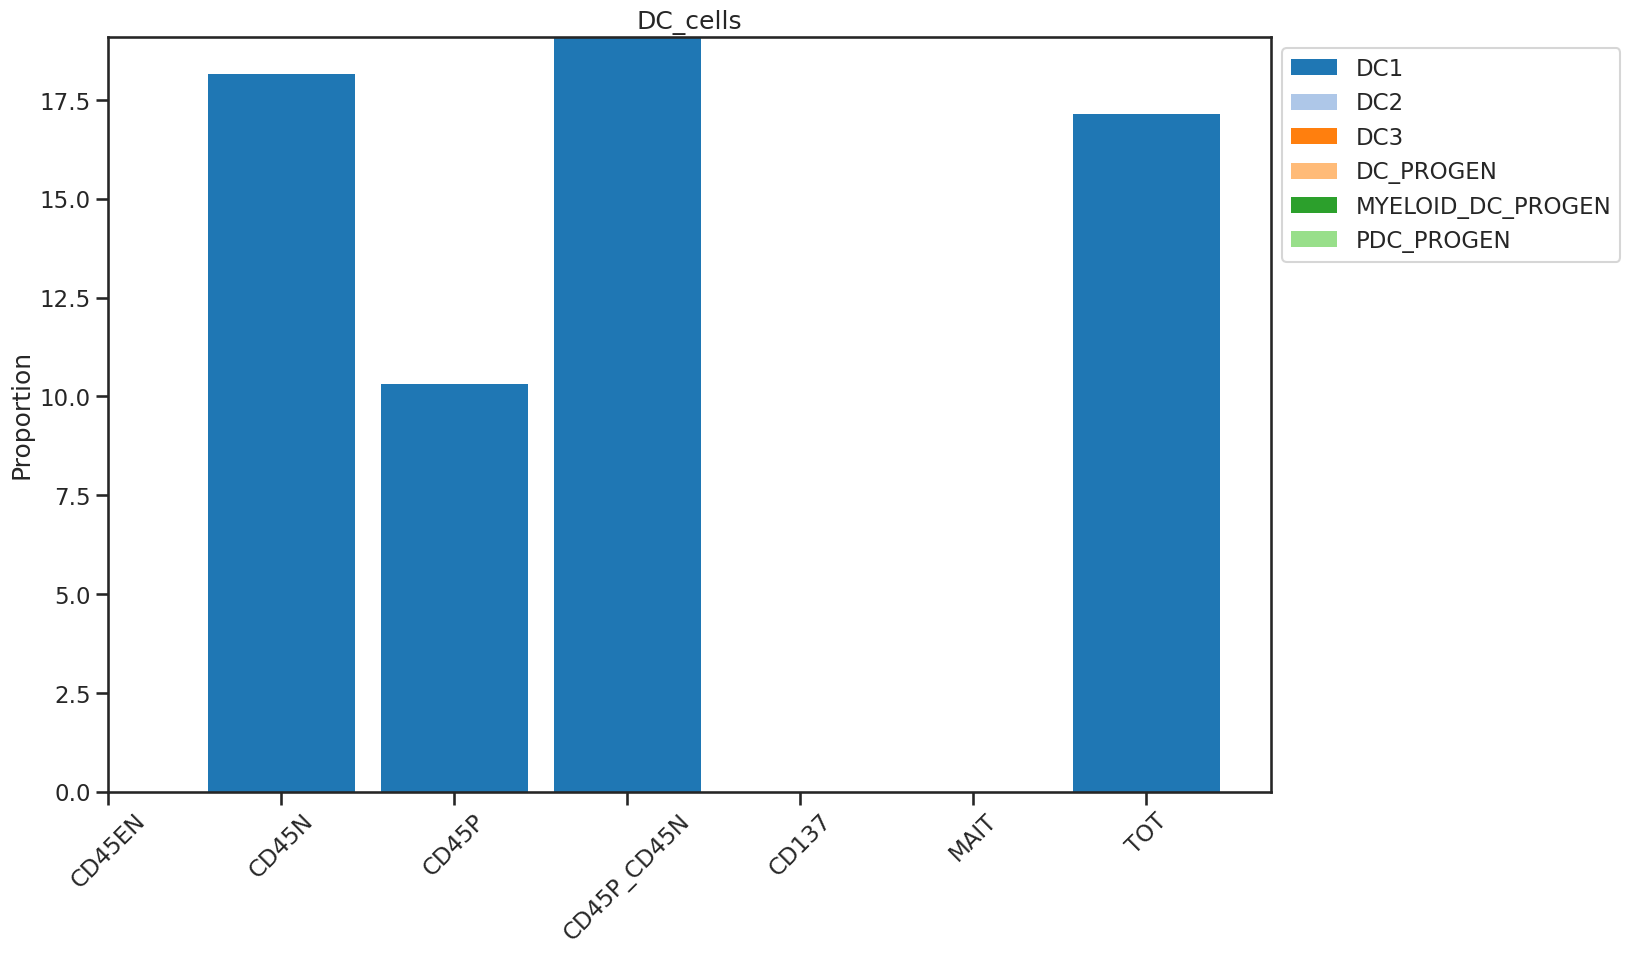

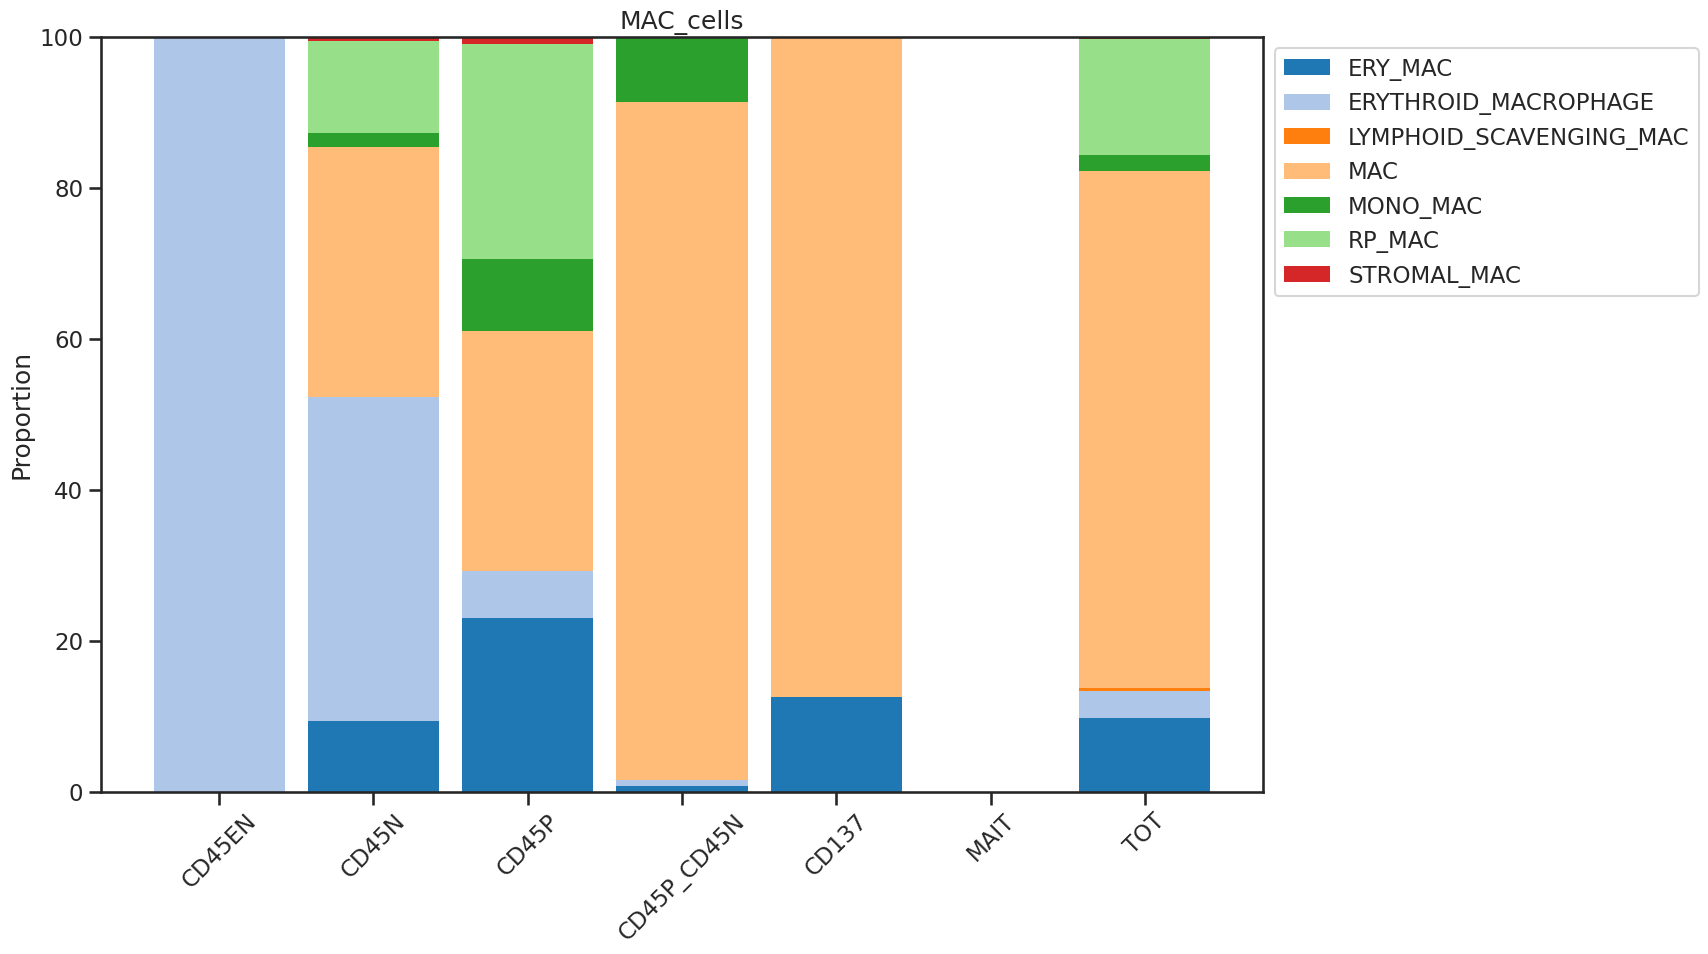

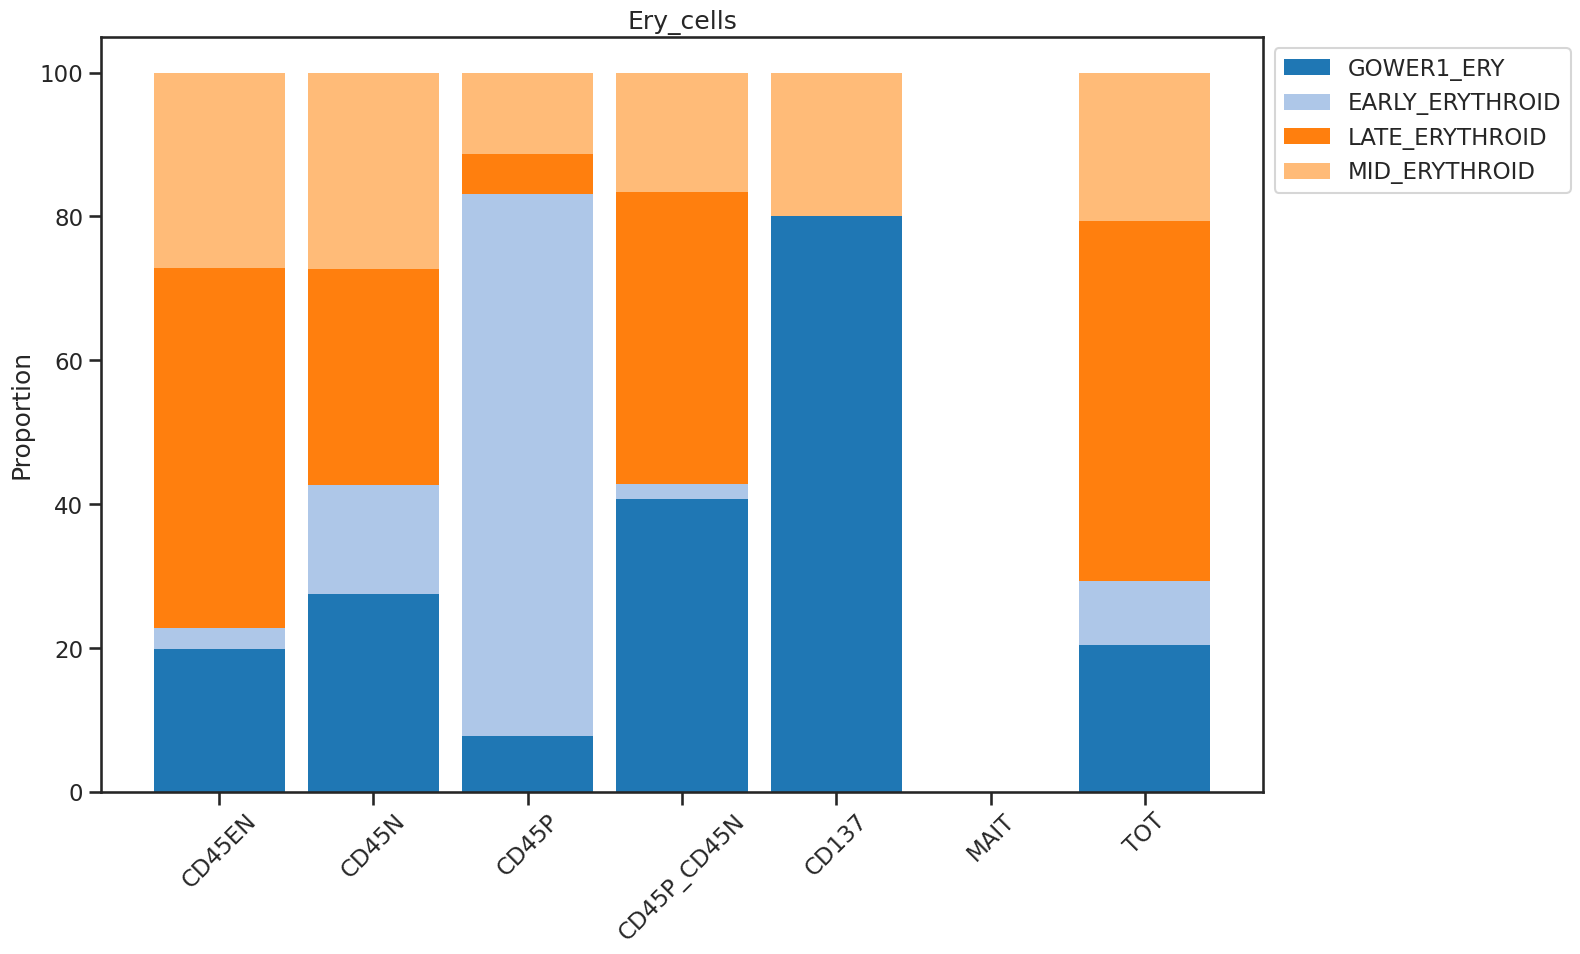

In [334]:
for k,g in anno_groups.items():
    viz.stacked_barplot(data_all[:, g], feature_name="Sort_id");
    plt.title(k)

## Old VS new annotation

In [427]:
def make_anno_confusion(anno_df, old_anno="old_anno", new_anno="anno_lvl_2"):
    anno_df["count"] = 1
    conf_df = anno_df.groupby([new_anno, old_anno]).sum().reset_index()
    conf_df.columns = ["new_anno", "old_anno", "count"]
    conf_df = conf_df.pivot(index='old_anno', values="count", columns='new_anno')
    conf_df[conf_df.isna()] = 0
    return(conf_df)

In [244]:
ordered_label = adata_obs[adata_obs["isin_split_" + plot_split]][["uniform_label", "uniform_label_lvl0"]].drop_duplicates().sort_values("uniform_label_lvl0").uniform_label

### New annotation VS uniform annotation 

In [428]:
plot_split = "LYMPHOID"
conf_df = adata_obs[adata_obs["isin_split_" + plot_split]][["anno_lvl_1", "uniform_label"]]
conf_df = make_anno_confusion(conf_df, old_anno="uniform_label", new_anno="anno_lvl_1")

In [248]:
# ordered_label[ordered_label.isin(conf_df.columns)]
label_group = {'CD8aa':"T CELL", 'CMP':"PROGENITOR", 'DN T CELL':'T CELL', 'DP T CELL':'T CELL', 'ELP':'PROGENITOR', 'HSC_MPP':'PROGENITOR', 'ILC':"ILC",
       'MATURE B CELL':'B CELL', 'NK':"T CELL", 'NK T':"T CELL", 'PLASMA B CELL':"B CELL", 'PRE B CELL':"B CELL",
       'PRE PRO B CELL':"B CELL", 'PRO B CELL':"B CELL", 'PRO TO PRE B CELL':"B CELL", 'PROGENITOR':'PROGENITOR',
       'SP T CELL':'T CELL', 'TREG':'T CELL'}

In [249]:
ordered_cols = pd.DataFrame.from_dict([label_group]).T.reset_index().sort_values(0)['index']

In [430]:
conf_frac = conf_df/conf_df.sum(0)
conf_frac = conf_frac[conf_frac.sum(1) > 0.02] ## Remove low cell types
conf_frac = conf_frac[ordered_cols]

anno_tot = conf_df.sum(0)

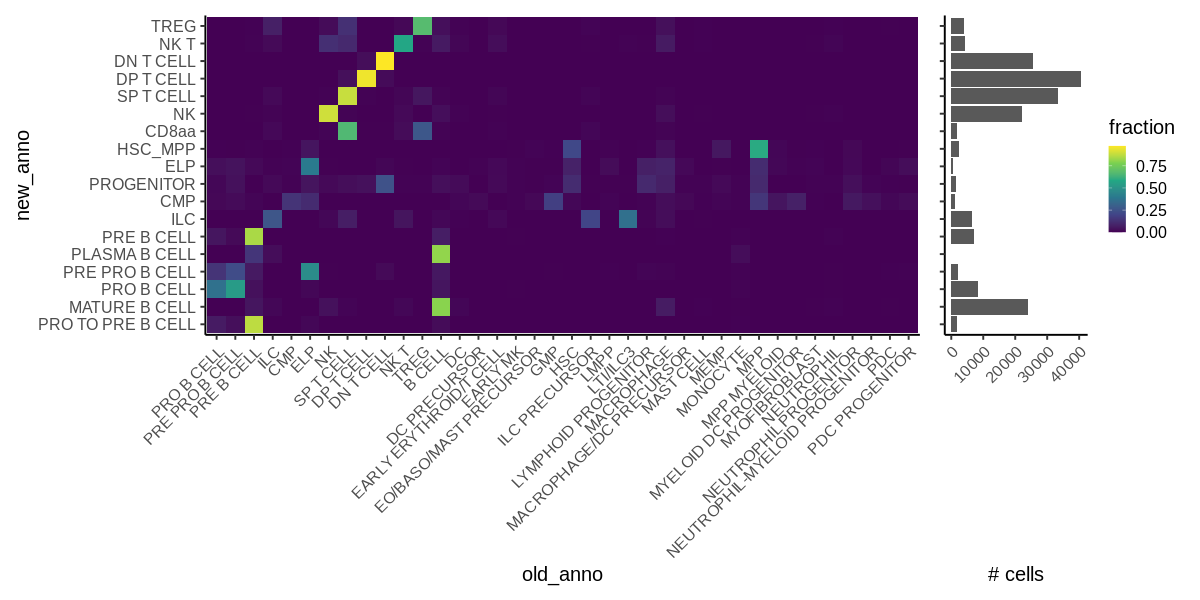

In [431]:
%%R -i conf_frac -i anno_tot -w 1200 -h 600
library(patchwork)

col_order = colnames(conf_frac)
row_order = c(col_order, rownames(conf_frac)[!rownames(conf_frac) %in% col_order])

pl1 <- conf_frac %>%
rownames_to_column("old_anno") %>%
pivot_longer(cols=-old_anno, names_to="new_anno", values_to="fraction") %>%
mutate(old_anno=factor(old_anno, levels=row_order)) %>%
mutate(new_anno=factor(new_anno, levels=col_order)) %>%
ggplot(aes(old_anno, new_anno, fill=fraction)) +
geom_tile() +
scale_fill_viridis_c() +
theme_classic(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))

pl2 <- data.frame(anno_tot) %>%
    rownames_to_column('new_anno') %>%
    mutate(new_anno=factor(new_anno, levels=col_order)) %>%
    ggplot(aes(new_anno, anno_tot)) +
    geom_col() +
#     scale_y_log10() +
    coord_flip() +
    ylab("# cells") +
    theme_classic(base_size=20) +
    theme(axis.text.y=element_blank(), axis.title.y=element_blank(),
         axis.text.x=element_text(angle=45, hjust=1, vjust=1))

pl1 + pl2 +
plot_layout(guides="collect", widths=c(5,1)) 

### New annotation VS detailed annotation for each organ

Not uniform across organs

In [398]:
def _translate_obs_names(x, organ):
    if organ in ["sp", 'bm']:
        if "FCA" in x:
            obs_name = x.split("_")[3]+ '-' +x.split("_")[5]
        else:
            obs_name = x
    elif organ in ["ki"]:
        if "FCA" in x:
            obs_name = x.split("_")[0] + "-" + x.split("_")[-1].split('-')[0]
        else:
            obs_name = x
    elif organ in ["li", 'ys']:
        obs_name = x.split("_")[3]+'-'+x.split("_")[4]
    elif organ in ["sk"]:
        obs_name = x.split("-")[2]+'-'+x.split("-")[0]
    elif organ in ["gu"]:
        obs_name = "-".join(x.split("-")[:2]) + "_" + x.split("-")[2]
    else:
        obs_name = x
    return(obs_name)

In [399]:
annot_dir = '/home/jovyan/mount/gdrive/Pan_fetal/annotations/'
annot_df = pd.read_csv(annot_dir + "uniform_labels_full.csv", index_col=0)
# annot_df.index = annot_df["old_name"]
annot_df.index = ["GEX".join(x.split("prime")) for x in annot_df.index]
new_name = [_translate_obs_names(annot_df.index[i],annot_df.organ[i]) for i in range(annot_df.shape[0])]

In [400]:
annot_df["old_name"] = annot_df.index
annot_df.index = new_name

In [406]:
annot_df.organ = [x.upper() for x in annot_df.organ]

In [516]:
new_annot_df = adata_obs[adata_obs["isin_split_" + plot_split]][["anno_lvl_2","organ"]]
new_annot_df.organ = ["TH" if x=="TH(pharyn)" else x for x in new_annot_df.organ]
conf_dict = {}
tot_dict = {}

for org in new_annot_df.organ.unique():
    new_annot_organ = new_annot_df[new_annot_df.organ==org]
    new_annot_organ = new_annot_organ.loc[new_annot_organ.index.isin(annot_df.index)]
    old_annot = annot_df.loc[new_annot_organ.index]["cell.labels"]
    new_annot_organ["old_anno"] = old_annot
    ## Compute confusion matrix
    conf_df = make_anno_confusion(new_annot_organ)
    conf_frac = conf_df/conf_df.sum(0)
    conf_frac = conf_frac[conf_frac.sum(1) > 0.02] ## Remove low cell types
    anno_tot = pd.DataFrame(conf_df.sum(0), columns=["n_cells"])
    anno_tot["organ"] = org
    conf_frac["organ"] = org
    conf_dict[org] = conf_frac
    tot_dict[org] = anno_tot
    
conf_df = pd.concat(conf_dict.values()).reset_index()
tot_df = pd.concat(tot_dict.values()).reset_index()

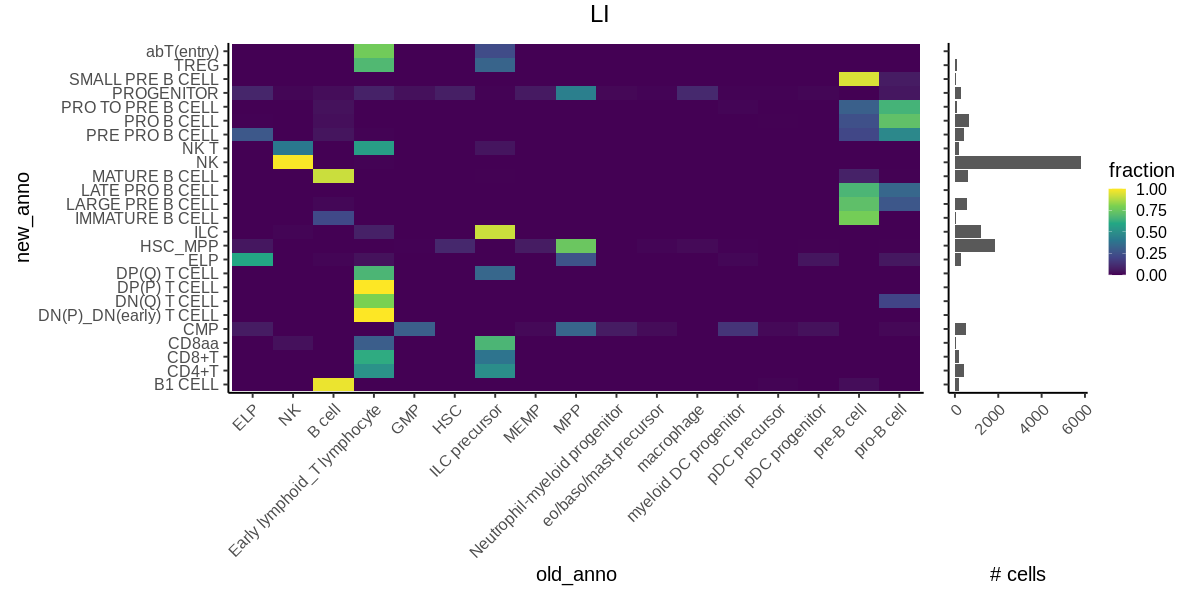

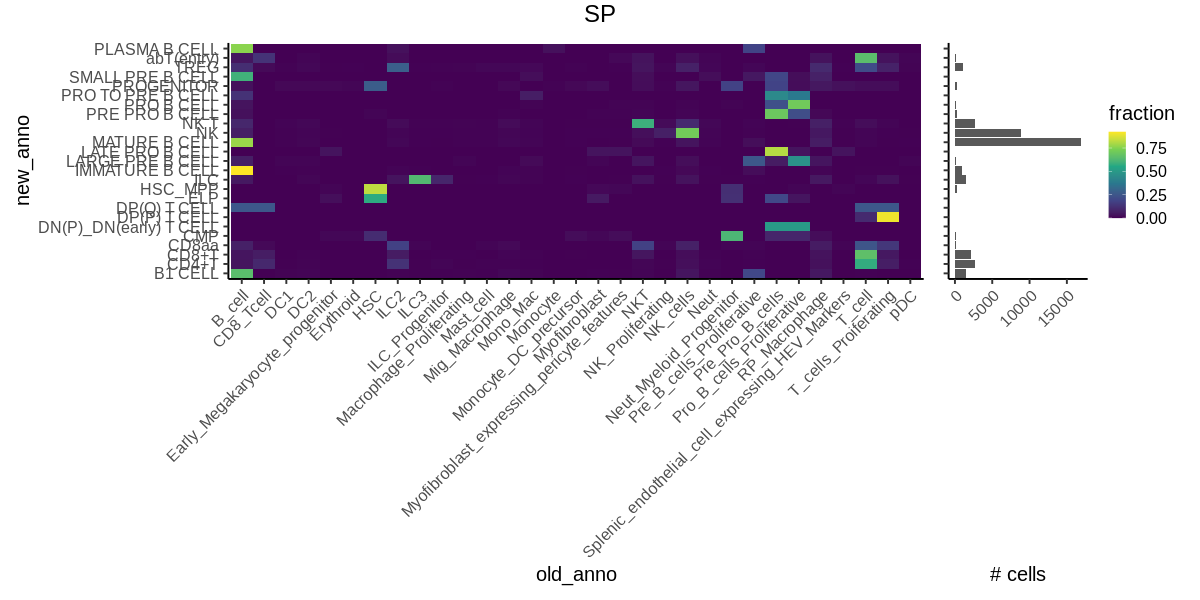

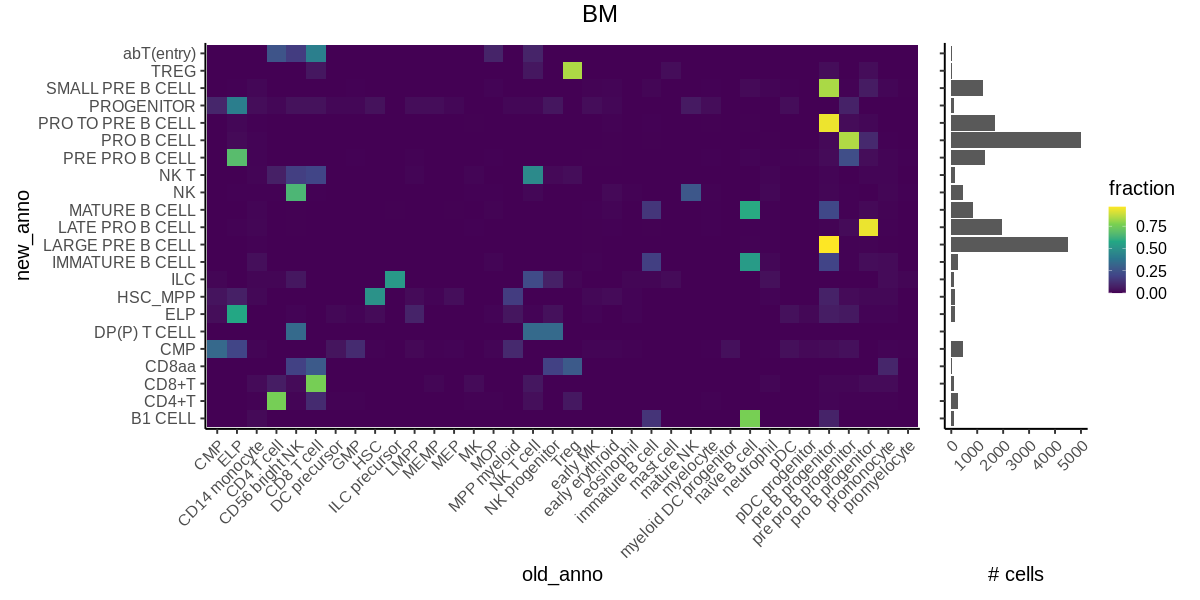

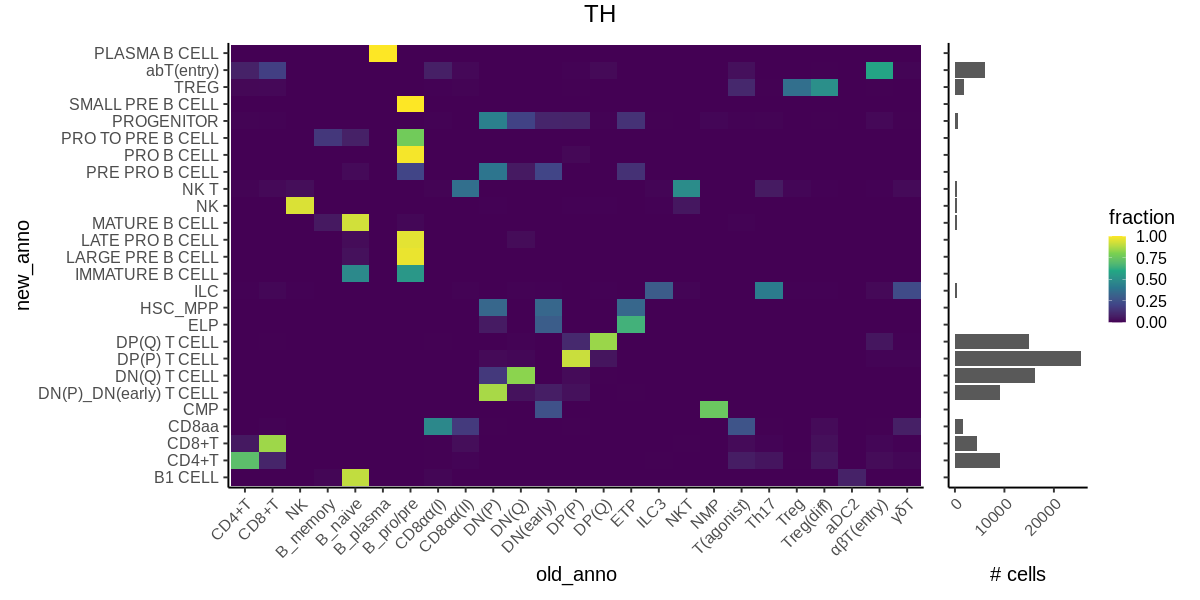

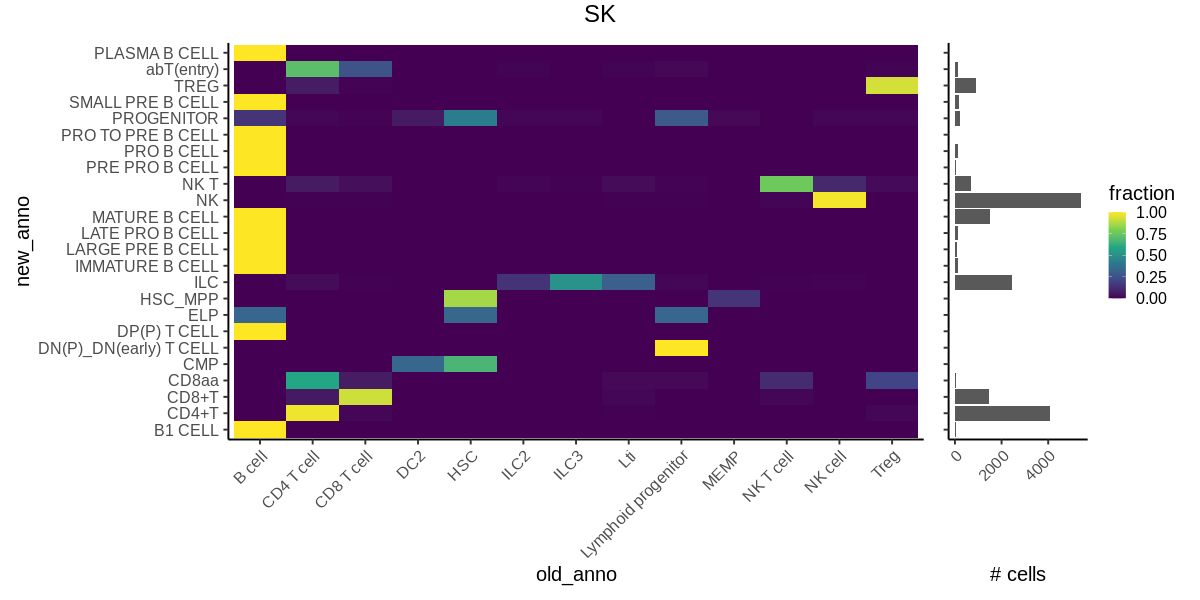

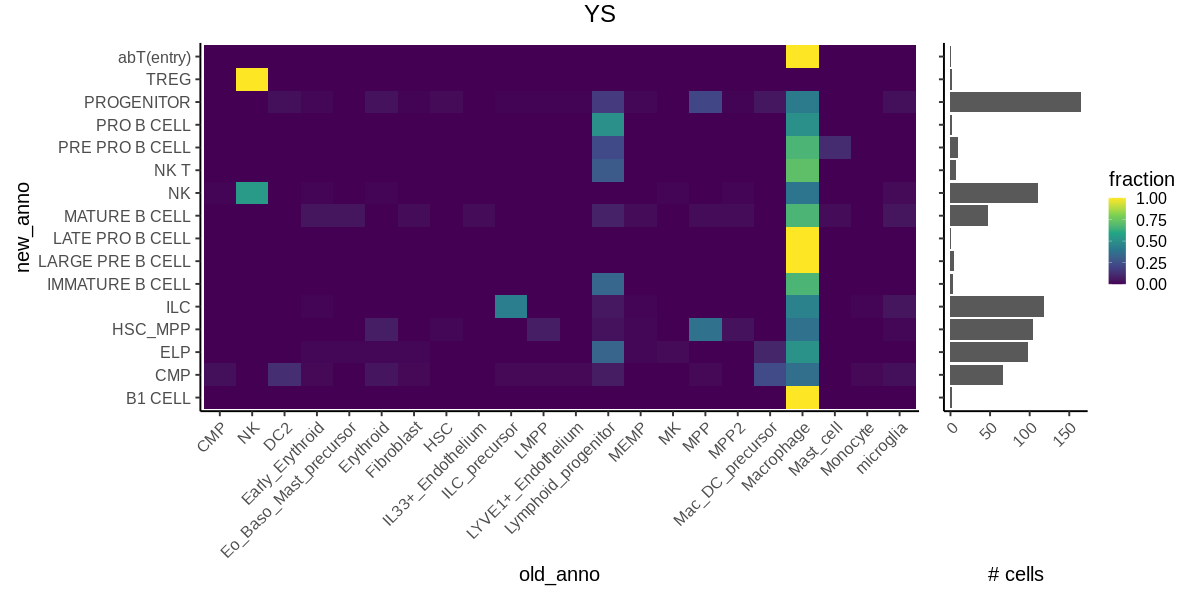

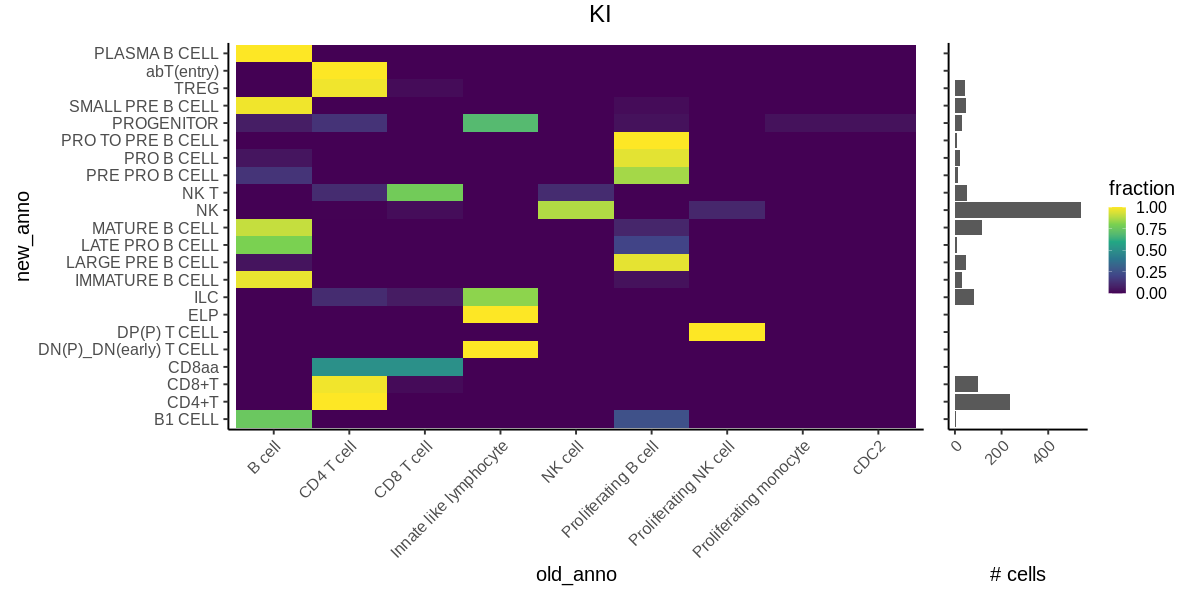

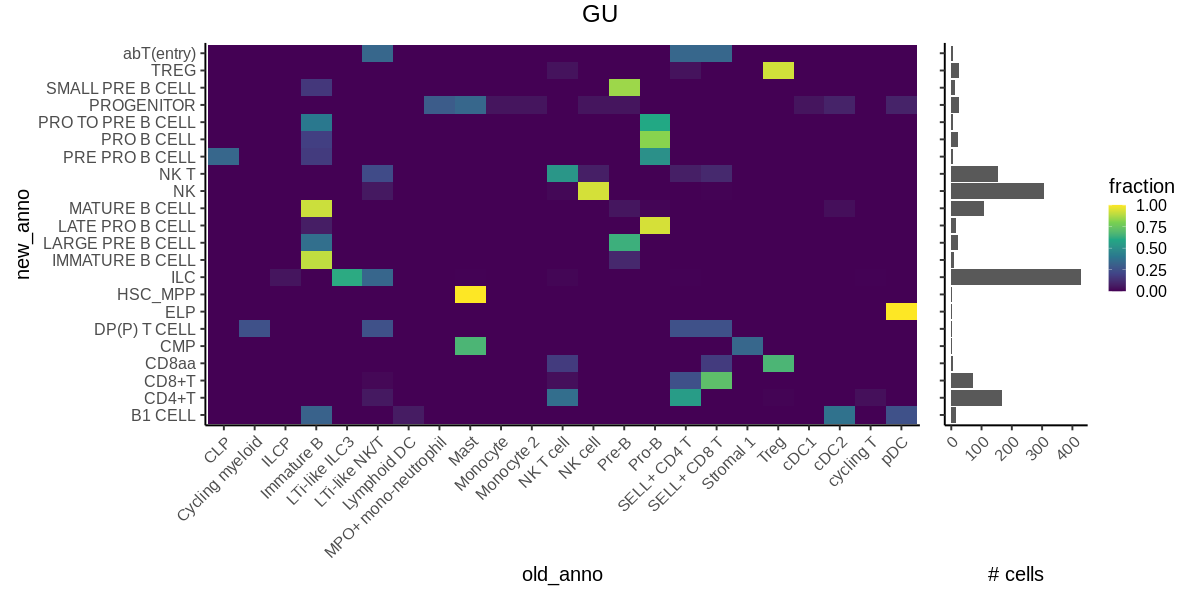

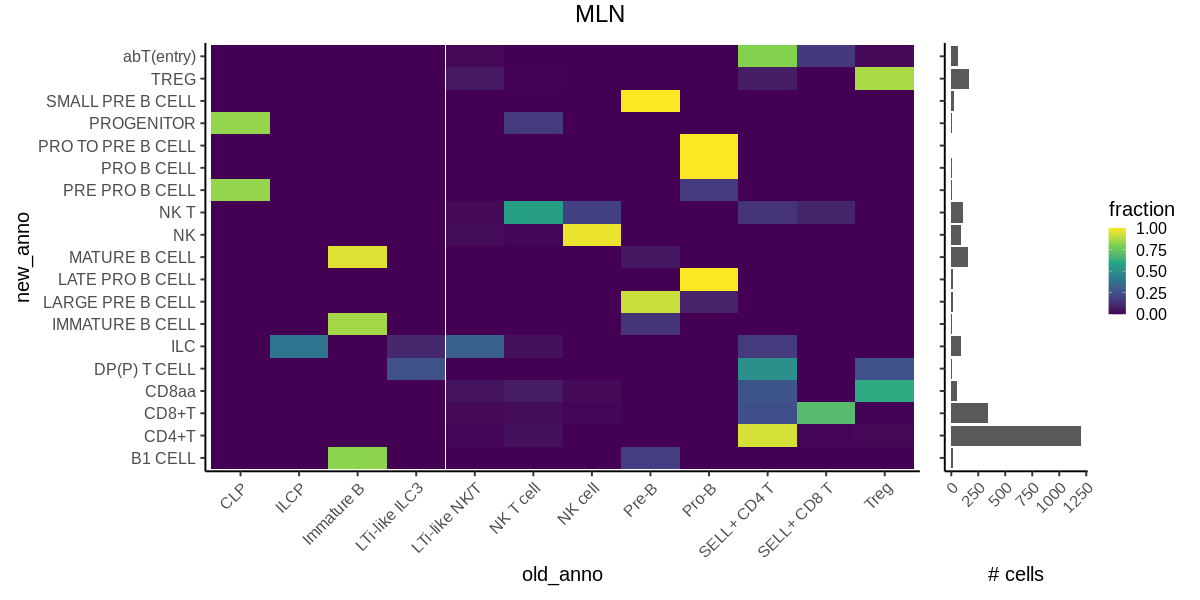

In [547]:
%%R -i conf_df -i tot_df -w 1200 -h 600
library(patchwork)
plot_confusion <- function(conf_frac, anno_tot){
     col_order = colnames(conf_frac)
    row_order = c(col_order, conf_frac$old_anno[!conf_frac$old_anno %in% col_order])

    pl1 <- conf_frac %>%
    pivot_longer(cols=-old_anno, names_to="new_anno", values_to="fraction") %>%
    mutate(old_anno=factor(old_anno, levels=row_order)) %>%
    mutate(new_anno=factor(new_anno, levels=col_order)) %>%
    drop_na() %>%
    ggplot(aes(old_anno, new_anno, fill=fraction)) +
    geom_tile() +
    scale_fill_viridis_c() +
    theme_classic(base_size=20) +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))

    pl2 <- data.frame(anno_tot) %>%
        mutate(new_anno=factor(new_anno, levels=col_order)) %>%
        ggplot(aes(new_anno, n_cells)) +
        geom_col() +
    #     scale_y_log10() +
        coord_flip() +
        ylab("# cells") +
        theme_classic(base_size=20) +
        theme(axis.text.y=element_blank(), axis.title.y=element_blank(),
             axis.text.x=element_text(angle=45, hjust=1, vjust=1))

    pl1 + pl2 +
    plot_layout(guides="collect", widths=c(5,1)) 
    }

for (org in unique(conf_df$organ)){
    c_df = conf_df %>%
        filter(organ==org) %>%
        select(- organ)
    t_df = tot_df %>%
        filter(organ==org) %>%
        select(- organ)
    print(plot_confusion(c_df, t_df) + 
         plot_annotation(title = org,
                  theme = theme(plot.title = element_text(size = 24, hjust=0.5))))
}